In [1]:
import os
import pandas as pd
import numpy as np
import warnings

from nilearn import datasets, plotting
import nibabel as nb
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import matplotlib as mpl

/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/745369509.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
start_folder = '/Users/Serena/Desktop/mega_last_results/results'

from definitions.backend_funcs import extract_results, plot_colorbar, fetch_surface

# min_beta, max_beta, mean_beta, n_clusters, sign_clusters, sign_betas, all_betas = extract_results(start_folder, 
#                                                                                                   'ADHD','Dopamine_ADHD', 'thickness')

In [3]:
def plot_single_brain(ax, hemi, coord, fig, sign_betas, 
                      surf='pial', resol = 'fsaverage5', colorblind=False):

    fs_avg, n_nodes = fetch_surface(resol)
    
    stats_map = sign_betas[hemi]  # sign_betas
    bg_color = fs_avg[f'sulc_{hemi}']

    # Add "ghosting" for hemisphere without significant clusters 
    bg_darkness = 0.2 if np.isnan(stats_map).all() else 0.6

    min_sign_beta = np.nanmin(stats_map)
    max_sign_beta = np.nanmax(stats_map)
    
    if max_sign_beta < 0 and min_sign_beta < 0:  # all negative associations
        cmap = 'viridis'
    elif max_sign_beta > 0 and min_sign_beta > 0:  # all positive associations
        cmap = 'viridis_r' if colorblind else 'hot_r'
    else:
        cmap = 'viridis' # TODO: could pick a diverging map for this one instead (rare though)

    p = plotting.plot_surf(surf_mesh=fs_avg[f'{surf}_{hemi}'],  # Surface mesh geometry
                           surf_map=stats_map[:n_nodes],  # Statistical map confounder model
                           bg_map=bg_color,
                           darkness=bg_darkness, # darkness of the bg_map
                           hemi=hemi,
                           view=coord,
                           cmap=cmap,
                           symmetric_cmap=False,
                           axes=ax,
                           figure=fig,
                           colorbar=False)
    return p

def plot_colorbar(ax1, ax2, sign_betas, all_betas, colorblind=False, set_range=None):

    obs_betas = np.concatenate((all_betas['left'], all_betas['right']), axis=None)
    min_obs_beta = np.nanmin(obs_betas)
    max_obs_beta = np.nanmax(obs_betas)
    # TMP: clean out all values exactly elqual to 0
    obs_betas = obs_betas[obs_betas != 0.00000]

    sign_betas = np.concatenate((sign_betas['left'], sign_betas['right']), axis=None)

    if all(np.isnan(sign_betas)):
        ax1.axis('off')
        ax2.axis('off')
        return None

    min_sign_beta = np.nanmin(sign_betas)
    max_sign_beta = np.nanmax(sign_betas)

    lspace = np.linspace(min_obs_beta, max_obs_beta, 200)
    color_where = (lspace > min_sign_beta) & (lspace < max_sign_beta)

    blank_middle = False

    if max_sign_beta < 0 and min_sign_beta < 0:  # all negative associations
        cmap = 'viridis'
    elif max_sign_beta > 0 and min_sign_beta > 0:  # all positive associations
        cmap = 'viridis_r' if colorblind else 'hot_r'
    else:
        cmap = 'viridis' # TODO: could pick a diverging map for this one instead (rare though)
        blank_middle = True
        thresh = np.nanmin(abs(sign_betas))
        color_where = (lspace > thresh) | (lspace < -thresh)

    # PLOT 1: COLORBAR -------------------------------------------------------------------------------

    cb1 = mpl.colorbar.ColorbarBase(ax1, 
                                    cmap=mpl.colormaps[cmap],
                                    norm=mpl.colors.Normalize(vmin=min_sign_beta, vmax=max_sign_beta),
                                    orientation='vertical', ticklocation='left')

    # Adjust colorbar margins, ticks and label
    # ticks = list(np.arange(margins[0], margins[1], tickstep))
    # tickform = '{:.1e}' if tickstep < 0.01 else '{:.2f}'
    # cb1.set_ticks(ticks, labels=[tickform.format(i) if i != 0 else '0.00' for i in ticks], fontsize=12)
    cb1.set_label(r'Observed $\beta$ values', fontsize=10, labelpad=5)

    # Include central threshold for maps with both positive and negative values
    if blank_middle:
        ax1.axhspan(-thresh, thresh, facecolor='white', alpha=0.99)

    if set_range == None:
        pad = abs(max_obs_beta - min_obs_beta) * 0.01  # use 1% of total range for upper and lower bounds
        ax1.set_ylim(min_obs_beta - pad, max_obs_beta + pad)
    else: 
        ax1.set_ylim(set_range[0], set_range[1])

    # PLOT 2: HISTOGRAM -------------------------------------------------------------------------------
    density = gaussian_kde(obs_betas)

    # Density line
    ax2.plot(density(lspace), lspace, lw=0.5, alpha=0.3, color='k')

    # Color significant portion
    polygon = ax2.fill_betweenx(y=lspace, x1=density(lspace), where=color_where, lw=0, color='none')
    verts = np.vstack([p.vertices for p in polygon.get_paths()])

    gradient = ax2.imshow(np.linspace(0, 1, 256).reshape(-1, 1),
                          cmap=cmap, aspect='auto',
                          extent=[verts[:, 0].max(), verts[:, 0].min(), verts[:, 1].max(), verts[:, 1].min()])
    gradient.set_clip_path(polygon.get_paths()[0], transform=ax2.transData)

    ax2.axhline(y=0, dashes=(20, 5), lw=0.2, alpha=0.3, color='k')

    if set_range == None:
        ax2.set_ylim(min_obs_beta - pad, max_obs_beta + pad)
    else: 
        ax2.set_ylim(set_range[0], set_range[1])

    ax2.set_xlim(0, np.nanmax(density(lspace)))

    ax2.axis('off')


def plot_brain_2d(start_folder, outc='SZC', model='Dopamine_SZC', meas='thickness', 
                  output_folder=None, save_figure=True, set_colorbar_range=None,
                  title = None, resol = 'fsaverage5', colorblind=False, figsize=(12, 7)):

    title = f'{model} ({meas})' if title == None else title

    print(f'Plotting ...')

    _, _, _, _, _, sign_betas, all_observed_betas = extract_results(start_folder, outc, model, meas)
    
    fig, axs = plt.subplot_mosaic('ABCDD.....;'+
                                  'ABCDD..a.b;'+
                                  'EFG.HH.a.b;'+
                                  'EFG.HH....', 
                                  figsize=figsize, per_subplot_kw={('ABCDEFGH'): {'projection': '3d'}},
                                  gridspec_kw=dict(wspace=0, hspace=0, 
                                                   width_ratios=[0.19, 0.19, 0.19, 0.02, 0.17,  # A-E, B-F, C-G, D-., D-H
                                                                 0.02, 0.07, 0.02, 0.01, 0.05], # .-H, ., .-a-., ., .-b-.
                                                   height_ratios=[.15, 1, 1, .15] # make the beta bar only  a bit smaller
                                                  ))

    kargs = dict(sign_betas=sign_betas, fig=fig, surf='pial', resol = resol, colorblind=colorblind)
    tkargs = dict(ha='center', va='center', style='italic', fontsize=10)
    
    plot_single_brain(axs['A'], 'left', 'lateral', **kargs)
    plot_single_brain(axs['B'], 'right', 'lateral', **kargs)
    
    plot_single_brain(axs['C'], 'left', 'dorsal', **kargs)
    plot_single_brain(axs['C'], 'right', 'dorsal', **kargs)

    plot_single_brain(axs['D'], 'left', 'posterior', **kargs)
    plot_single_brain(axs['D'], 'right', 'posterior', **kargs)
    
    plot_single_brain(axs['E'], 'left', 'medial', **kargs)
    plot_single_brain(axs['F'], 'right', 'medial', **kargs)
    
    plot_single_brain(axs['G'], 'left', 'ventral', **kargs)
    plot_single_brain(axs['G'], 'right', 'ventral', **kargs)

    plot_single_brain(axs['H'], 'left', 'anterior', **kargs)
    plot_single_brain(axs['H'], 'right', 'anterior', **kargs)

    # Move laternal and medial views closer together
    axs['A'].set_ylim3d(-88, 90)
    axs['B'].set_ylim3d(-88, 90)
    
    axs['E'].set_ylim3d(-128, 50)
    axs['F'].set_ylim3d(-128, 50)

    # Add colorbar 
    plot_colorbar(axs['a'], axs['b'], sign_betas, all_observed_betas, colorblind=colorblind, set_range=set_colorbar_range)
    axs['a'].set_zorder(100) # make sure labels are not covered
    
    # Add title
    fig.suptitle(title, fontsize=14, fontweight='bold', y=.87)

    # Add legend text -------------------------------------------------------------------
    
    # View
    y_top, y_bot = 0.54, 0.15
    x_1, x_2, x_3 = 0.285, 0.525, 0.69
    
    tkargs = dict(ha='center', va='center', style='italic', fontsize=10)
    
    fig.text(x_1, y_top, "Lateral\nview", **tkargs)
    fig.text(x_2, y_top, "Dorsal\nview", **tkargs)
    fig.text(x_3, y_top, "Posterior\nview", **tkargs)
    
    fig.text(x_1, y_bot, "Medial\nview", **tkargs)
    fig.text(x_2, y_bot, "Ventral\nview", **tkargs)
    fig.text(x_3, y_bot, "Anterior\nview", **tkargs)

    # Left vs. right hemisphere
    y_top, y_bot = y_top+0.23, y_bot+0.23
    x_1a, x_1b = x_1-0.11, x_1+0.11
    x_2a = x_2b = x_2-0.06
    x_3a, x_3b = x_3-0.045, x_3+0.045

    lkargs = dict(ha='center', va='center', style='italic', fontsize=12, color='grey')
    
    fig.text(x_1a, y_top, "L", **lkargs); fig.text(x_1b, y_top, "R", **lkargs)
    fig.text(x_1a, y_bot, "L", **lkargs); fig.text(x_1b, y_bot, "R", **lkargs)
    
    fig.text(x_2a, y_top, "L", **lkargs); fig.text(x_2b, y_top-0.18, "R", **lkargs)
    fig.text(x_2a, y_bot, "L", **lkargs); fig.text(x_2b, y_bot-0.18, "R", **lkargs)
    
    fig.text(x_3a, y_top, "L", **lkargs); fig.text(x_3b, y_top, "R", **lkargs)
    fig.text(x_3a, y_bot, "R", **lkargs); fig.text(x_3b, y_bot, "L", **lkargs)
    
    # Save the figure ---------------------------------------------------------------------
    if save_figure:
        
        if output_folder == None: 
            output_folder = start_folder 
    
        figfile_name = f'{output_folder}/_{model}_{meas}.png'
        
        print(f'Saving figure "{model}_{meas}" ...')
        
        plt.savefig(figfile_name, bbox_inches='tight', dpi=400)

    return fig

In [4]:
import matplotlib.image as mpimg
from string import ascii_uppercase as letters
import os.path


def plot_all_models(outc, meas, resol='fsaverage', colorbar_range = [-.2, .2],
                    start_folder = '/Users/Serena/Desktop/mega_last_results/results',
                    output_folder = '/Users/Serena/Desktop/mega_last_results/figures'):
    
    models = [f'{outc}',
              f'Glutamate_{outc}', f'GABA_{outc}',
              f'Dopamine_{outc}', f'Serotonin_{outc}']

    if not os.path.isfile(f'{output_folder}/_{outc}_{meas}.png'):
        for mod in models: 
            if len(mod.split('_')) > 1:
                fig_title = mod.split('_')[0]
            else:
                fig_title = 'Genome-wide'
                
            f = plot_brain_2d(start_folder=start_folder, outc=outc, model=mod, meas=meas, 
                              output_folder=output_folder, save_figure=True, 
                              title = fig_title, set_colorbar_range=colorbar_range);
            
    # Contruct mega figure
    print('Constructing mega figure...')
    megafig, axs = plt.subplot_mosaic('.AA.;'+
                                      '....;'+
                                      'BBCC;'+
                                      '....;'+
                                      'DDEE', 
                                      figsize=(12*2, 7*3),
                                      height_ratios=[1, .08, 1, .08, 1],
                                      gridspec_kw=dict(wspace=0, hspace=0))

    for i, mod in enumerate(models):

        axs[letters[i]].imshow(mpimg.imread(f'{output_folder}/_{mod}_{meas}.png'))
        axs[letters[i]].text(x=1, y=1, s=letters[i], fontsize=14, fontweight='bold', va='center',ha='left', 
                             bbox=dict(facecolor='silver', alpha=0.3, pad=5, edgecolor='white'))
        axs[letters[i]].axis('off')

    meas_name = 'Cortical surface area' if meas == 'area' else 'Cortical thickness'

    megafig.suptitle(f'{outc} - {meas_name}', fontsize=16, fontweight='bold', y=.9)

    print('Saving mega figure...')

    outc_name = 'SCZ' if outc == 'SZC' else 'p-factor' if outc == 'p' else outc
    figfile_name = f'{output_folder}/{outc_name}_{meas}.pdf'
    
    plt.savefig(figfile_name, bbox_inches='tight', dpi=400)
    
    return megafig

Plotting ...
Saving figure "MDD_area" ...
Plotting ...


/Users/Serena/Desktop/mega_last_results/BrainMapp/definitions/backend_funcs.py:82: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
/Users/Serena/Desktop/mega_last_results/BrainMapp/definitions/backend_funcs.py:82: RuntimeWarning: Mean of empty slice
  return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-pack

Saving figure "Glutamate_MDD_area" ...
Plotting ...


/Users/Serena/Desktop/mega_last_results/BrainMapp/definitions/backend_funcs.py:82: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
/Users/Serena/Desktop/mega_last_results/BrainMapp/definitions/backend_funcs.py:82: RuntimeWarning: Mean of empty slice
  return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-pack

Saving figure "GABA_MDD_area" ...
Plotting ...
Saving figure "Dopamine_MDD_area" ...
Plotting ...


/Users/Serena/Desktop/mega_last_results/BrainMapp/definitions/backend_funcs.py:82: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
/Users/Serena/Desktop/mega_last_results/BrainMapp/definitions/backend_funcs.py:82: RuntimeWarning: Mean of empty slice
  return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-pack

Saving figure "Serotonin_MDD_area" ...
Constructing mega figure...
Saving mega figure...
Plotting ...


/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:520: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(data) if vmax is None else vmax


Saving figure "MDD_thickness" ...
Plotting ...


/Users/Serena/Desktop/mega_last_results/BrainMapp/definitions/backend_funcs.py:82: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
/Users/Serena/Desktop/mega_last_results/BrainMapp/definitions/backend_funcs.py:82: RuntimeWarning: Mean of empty slice
  return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-pack

Saving figure "Glutamate_MDD_thickness" ...
Plotting ...


/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:520: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(data) if vmax is None else vmax


Saving figure "GABA_MDD_thickness" ...
Plotting ...


/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:520: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(data) if vmax is None else vmax


Saving figure "Dopamine_MDD_thickness" ...
Plotting ...


/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:520: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(data) if vmax is None else vmax


Saving figure "Serotonin_MDD_thickness" ...
Constructing mega figure...
Saving mega figure...
Plotting ...
Saving figure "ADHD_area" ...
Plotting ...
Saving figure "Glutamate_ADHD_area" ...
Plotting ...
Saving figure "GABA_ADHD_area" ...
Plotting ...
Saving figure "Dopamine_ADHD_area" ...
Plotting ...


/Users/Serena/Desktop/mega_last_results/BrainMapp/definitions/backend_funcs.py:82: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
/Users/Serena/Desktop/mega_last_results/BrainMapp/definitions/backend_funcs.py:82: RuntimeWarning: Mean of empty slice
  return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-pack

Saving figure "Serotonin_ADHD_area" ...
Constructing mega figure...
Saving mega figure...
Plotting ...


/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:520: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(data) if vmax is None else vmax


Saving figure "ADHD_thickness" ...
Plotting ...
Saving figure "Glutamate_ADHD_thickness" ...
Plotting ...


/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:128: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplot_mosaic('ABCDD.....;'+


Saving figure "GABA_ADHD_thickness" ...
Plotting ...
Saving figure "Dopamine_ADHD_thickness" ...
Plotting ...


/Users/Serena/Desktop/mega_last_results/BrainMapp/definitions/backend_funcs.py:82: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
/Users/Serena/Desktop/mega_last_results/BrainMapp/definitions/backend_funcs.py:82: RuntimeWarning: Mean of empty slice
  return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-pack

Saving figure "Serotonin_ADHD_thickness" ...
Constructing mega figure...
Saving mega figure...
Plotting ...
Saving figure "SZC_area" ...
Plotting ...
Saving figure "Glutamate_SZC_area" ...
Plotting ...
Saving figure "GABA_SZC_area" ...
Plotting ...


/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:520: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(data) if vmax is None else vmax


Saving figure "Dopamine_SZC_area" ...
Plotting ...
Saving figure "Serotonin_SZC_area" ...
Constructing mega figure...
Saving mega figure...
Plotting ...


/Users/Serena/Desktop/mega_last_results/BrainMapp/definitions/backend_funcs.py:82: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
/Users/Serena/Desktop/mega_last_results/BrainMapp/definitions/backend_funcs.py:82: RuntimeWarning: Mean of empty slice
  return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-pack

Saving figure "SZC_thickness" ...
Plotting ...


/Users/Serena/Desktop/mega_last_results/BrainMapp/definitions/backend_funcs.py:82: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
/Users/Serena/Desktop/mega_last_results/BrainMapp/definitions/backend_funcs.py:82: RuntimeWarning: Mean of empty slice
  return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-pack

Saving figure "Glutamate_SZC_thickness" ...
Plotting ...
Saving figure "GABA_SZC_thickness" ...
Plotting ...


/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:520: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(data) if vmax is None else vmax


Saving figure "Dopamine_SZC_thickness" ...
Plotting ...


/Users/Serena/Desktop/mega_last_results/BrainMapp/definitions/backend_funcs.py:82: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
/Users/Serena/Desktop/mega_last_results/BrainMapp/definitions/backend_funcs.py:82: RuntimeWarning: Mean of empty slice
  return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-pack

Saving figure "Serotonin_SZC_thickness" ...
Constructing mega figure...
Saving mega figure...
Plotting ...
Saving figure "p_area" ...
Plotting ...
Saving figure "Glutamate_p_area" ...
Plotting ...


/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:520: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(data) if vmax is None else vmax


Saving figure "GABA_p_area" ...
Plotting ...


/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:520: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(data) if vmax is None else vmax


Saving figure "Dopamine_p_area" ...
Plotting ...


/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:520: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(data) if vmax is None else vmax


Saving figure "Serotonin_p_area" ...
Constructing mega figure...
Saving mega figure...
Plotting ...


/Users/Serena/Desktop/mega_last_results/BrainMapp/definitions/backend_funcs.py:82: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
/Users/Serena/Desktop/mega_last_results/BrainMapp/definitions/backend_funcs.py:82: RuntimeWarning: Mean of empty slice
  return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-pack

Saving figure "p_thickness" ...
Plotting ...


/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:520: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(data) if vmax is None else vmax


Saving figure "Glutamate_p_thickness" ...
Plotting ...


/Users/Serena/Desktop/mega_last_results/BrainMapp/definitions/backend_funcs.py:82: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
/Users/Serena/Desktop/mega_last_results/BrainMapp/definitions/backend_funcs.py:82: RuntimeWarning: Mean of empty slice
  return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-pack

Saving figure "GABA_p_thickness" ...
Plotting ...


/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:520: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(data) if vmax is None else vmax


Saving figure "Dopamine_p_thickness" ...
Plotting ...


/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:12: RuntimeWarning: All-NaN slice encountered
  min_sign_beta = np.nanmin(stats_map)
/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_19307/3834045631.py:13: RuntimeWarning: All-NaN slice encountered
  max_sign_beta = np.nanmax(stats_map)
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:519: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(data) if vmin is None else vmin
/Users/Serena/.pyenv/versions/3.9.1/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:520: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(data) if vmax is None else vmax


Saving figure "Serotonin_p_thickness" ...
Constructing mega figure...
Saving mega figure...


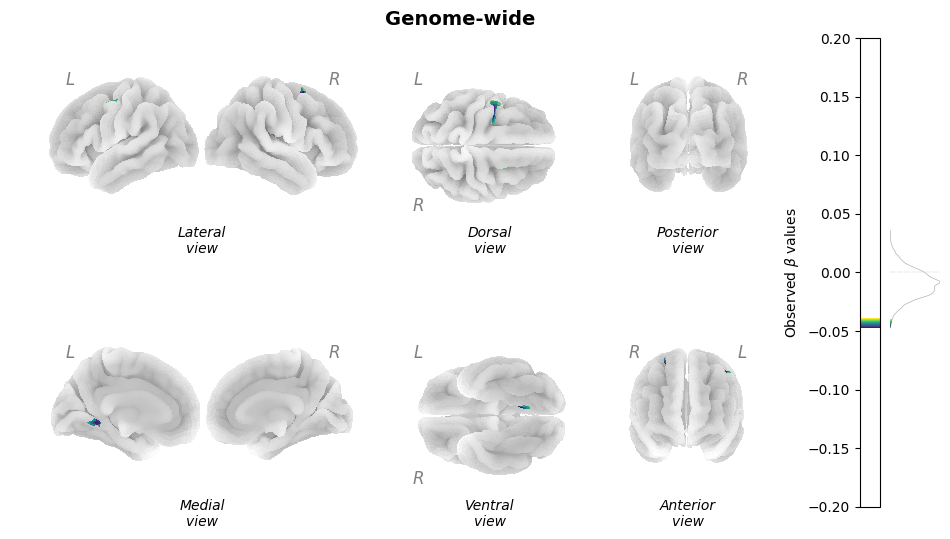

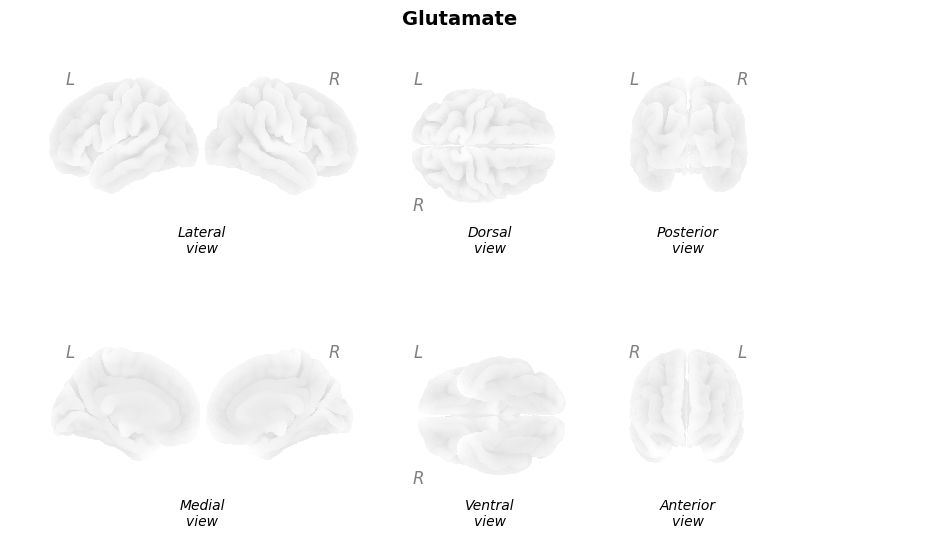

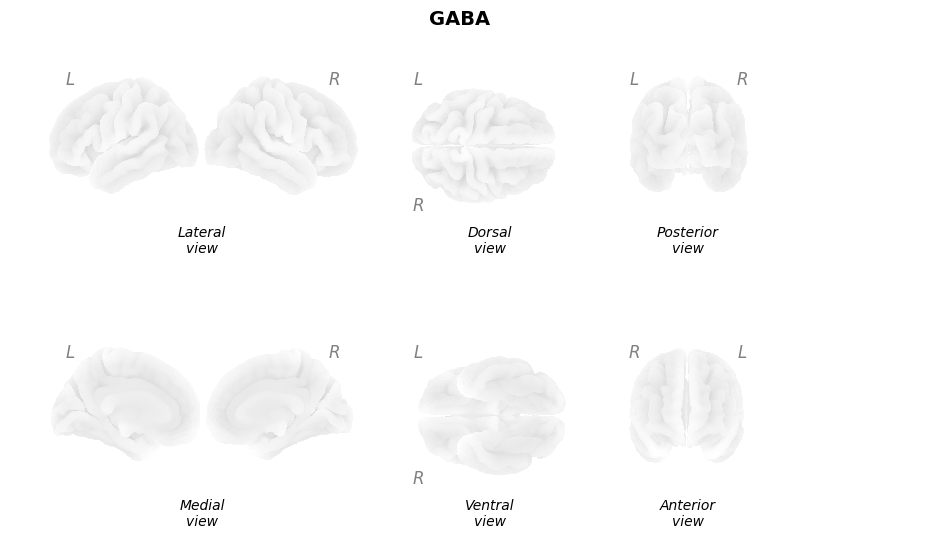

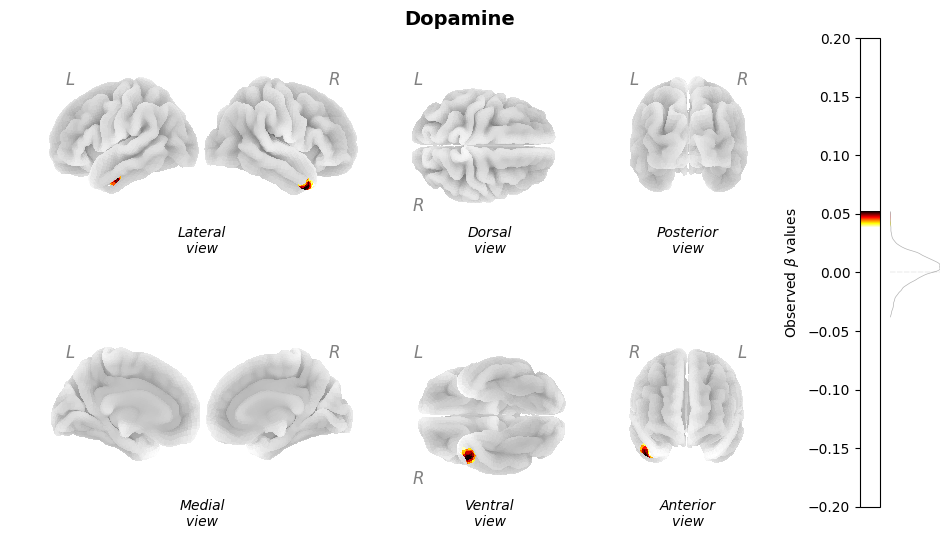

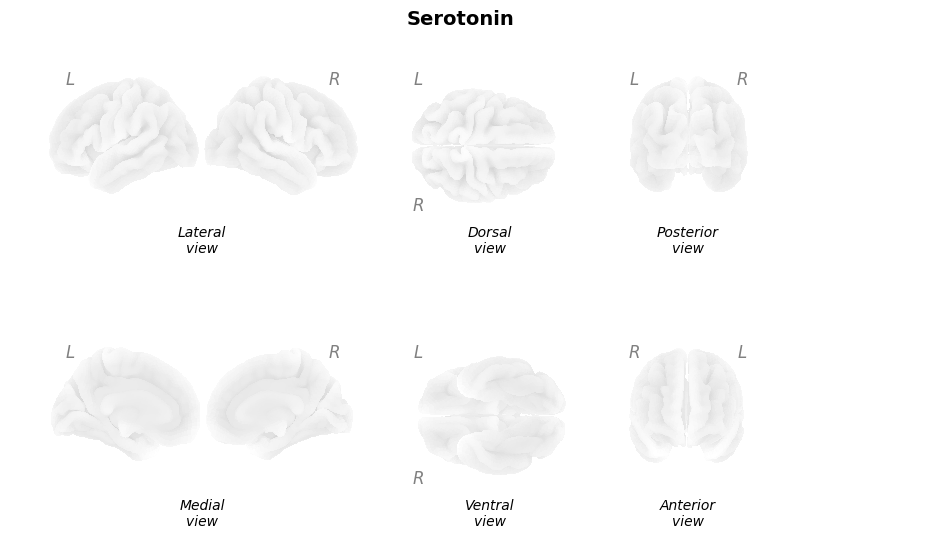

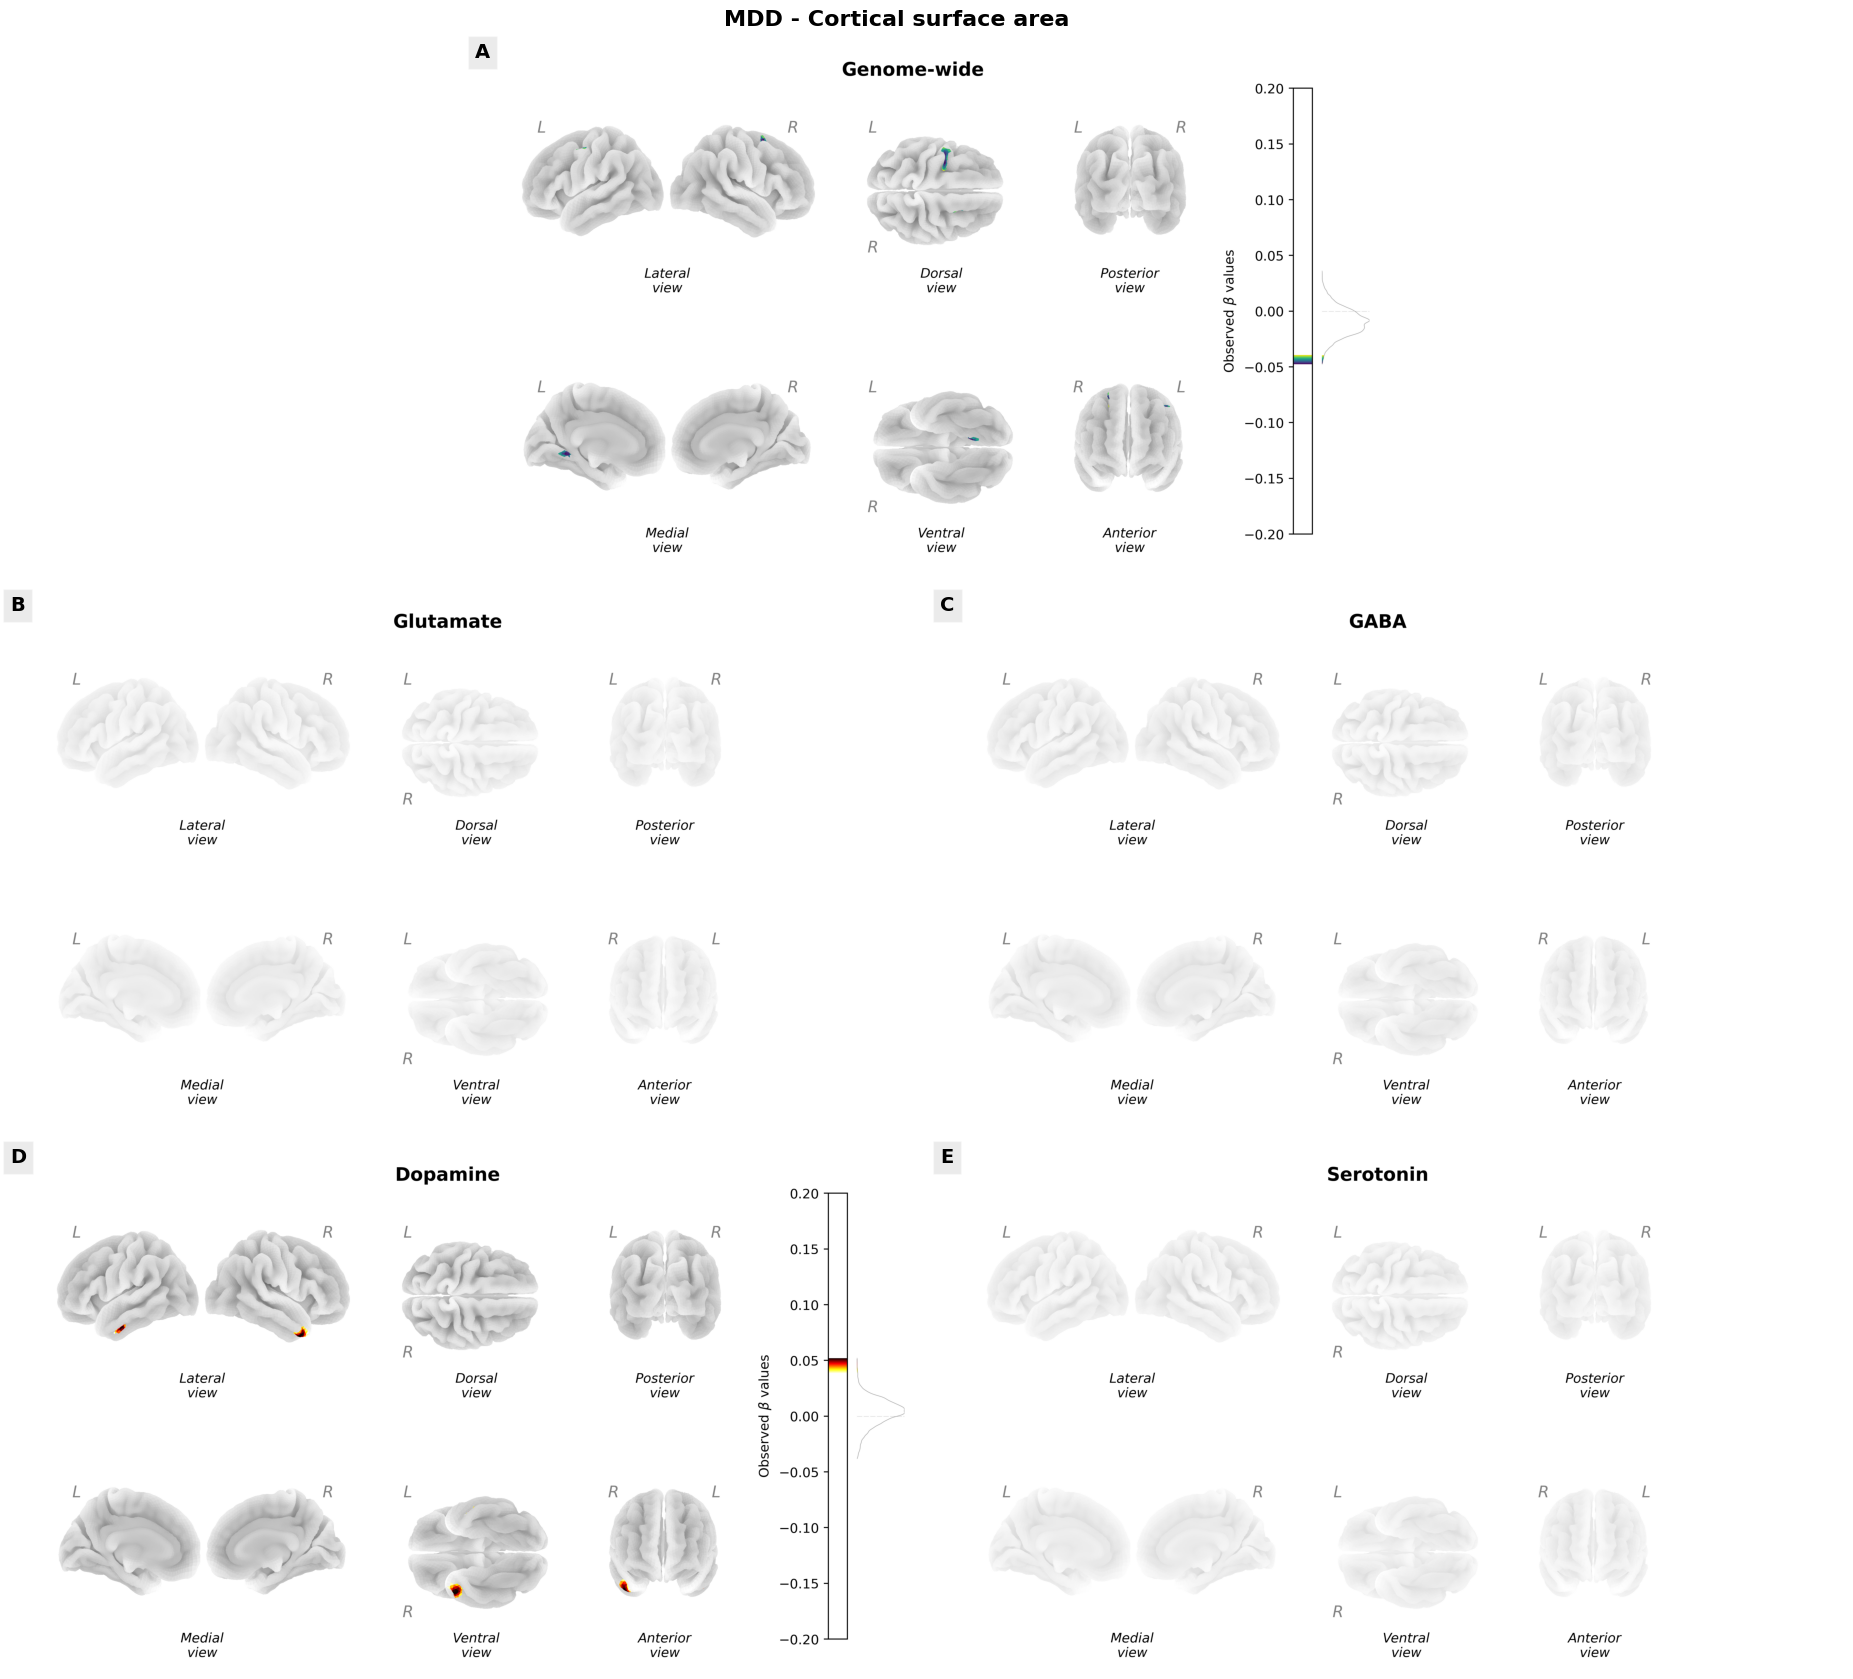

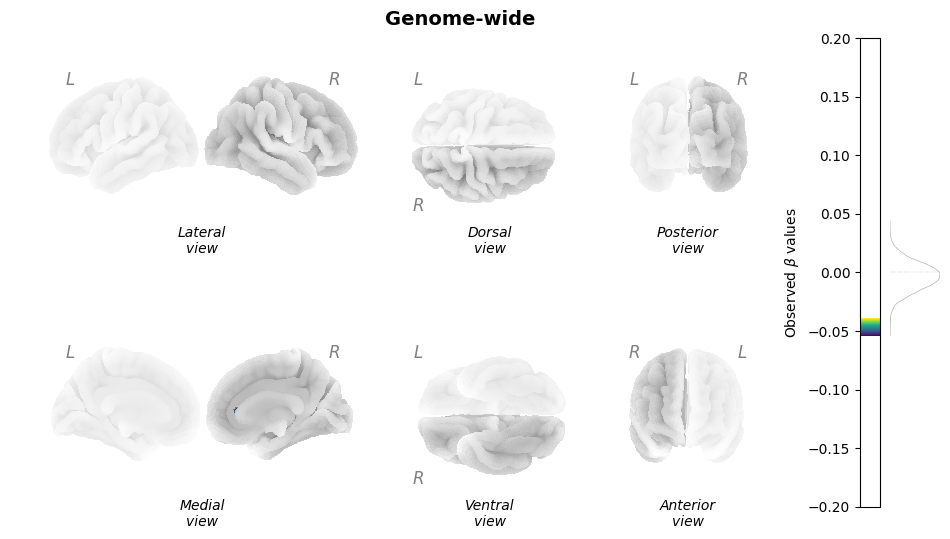

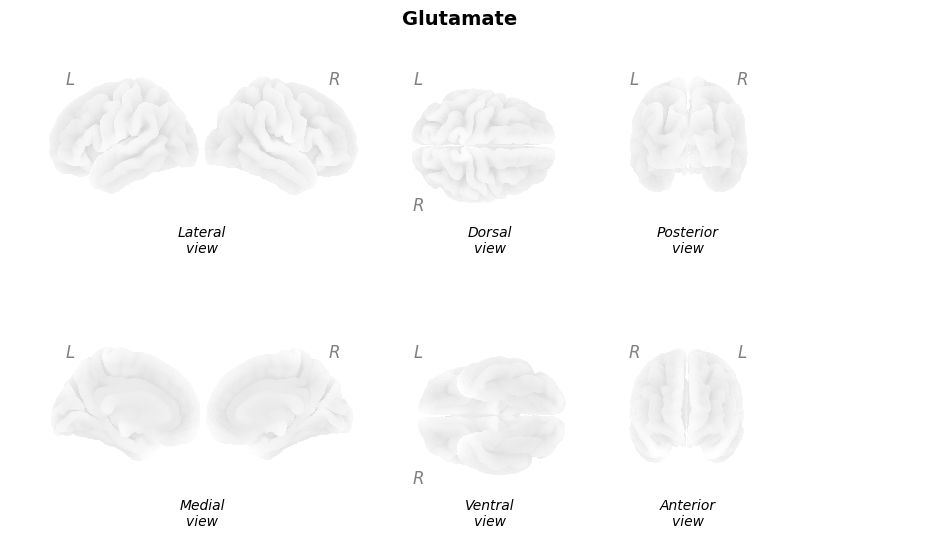

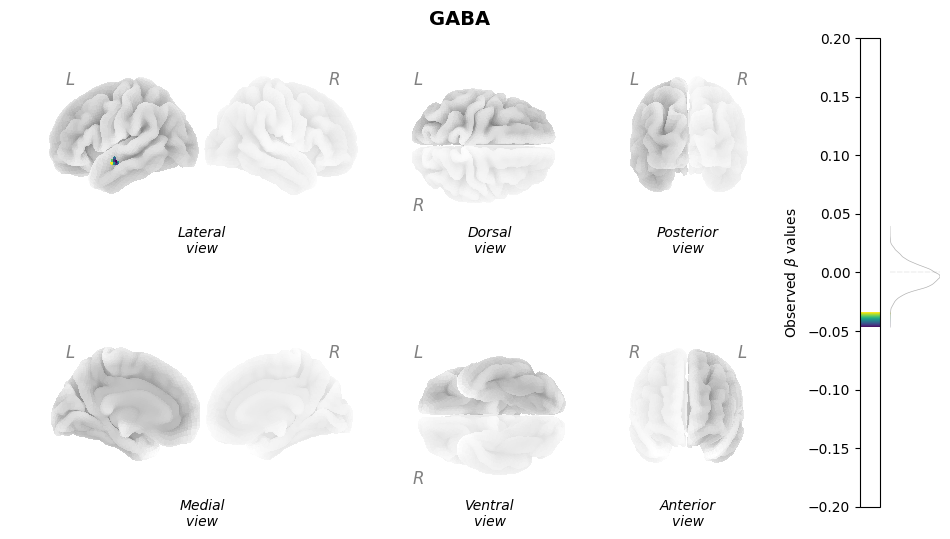

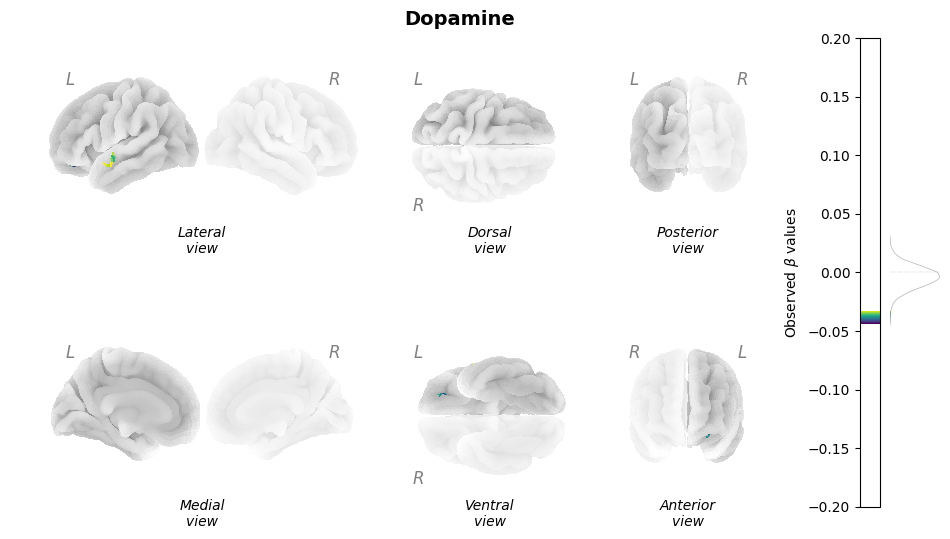

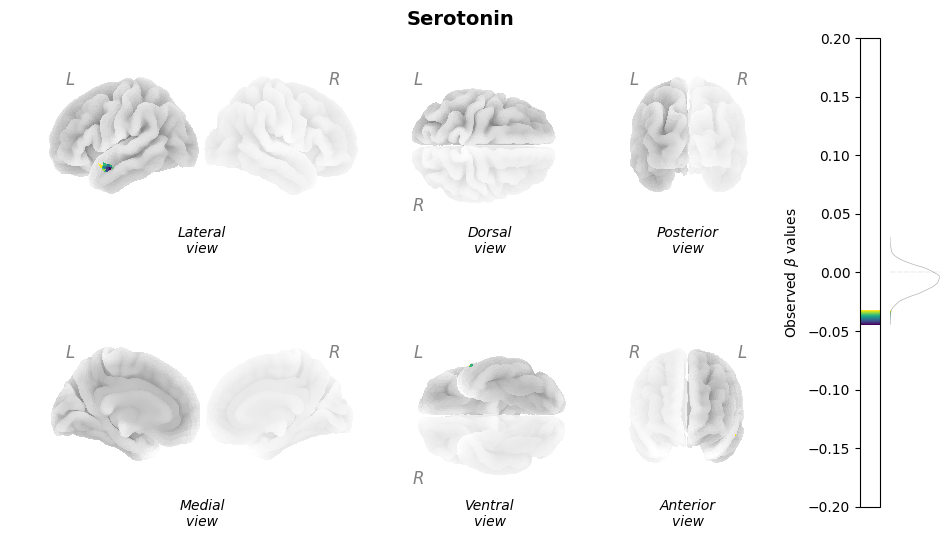

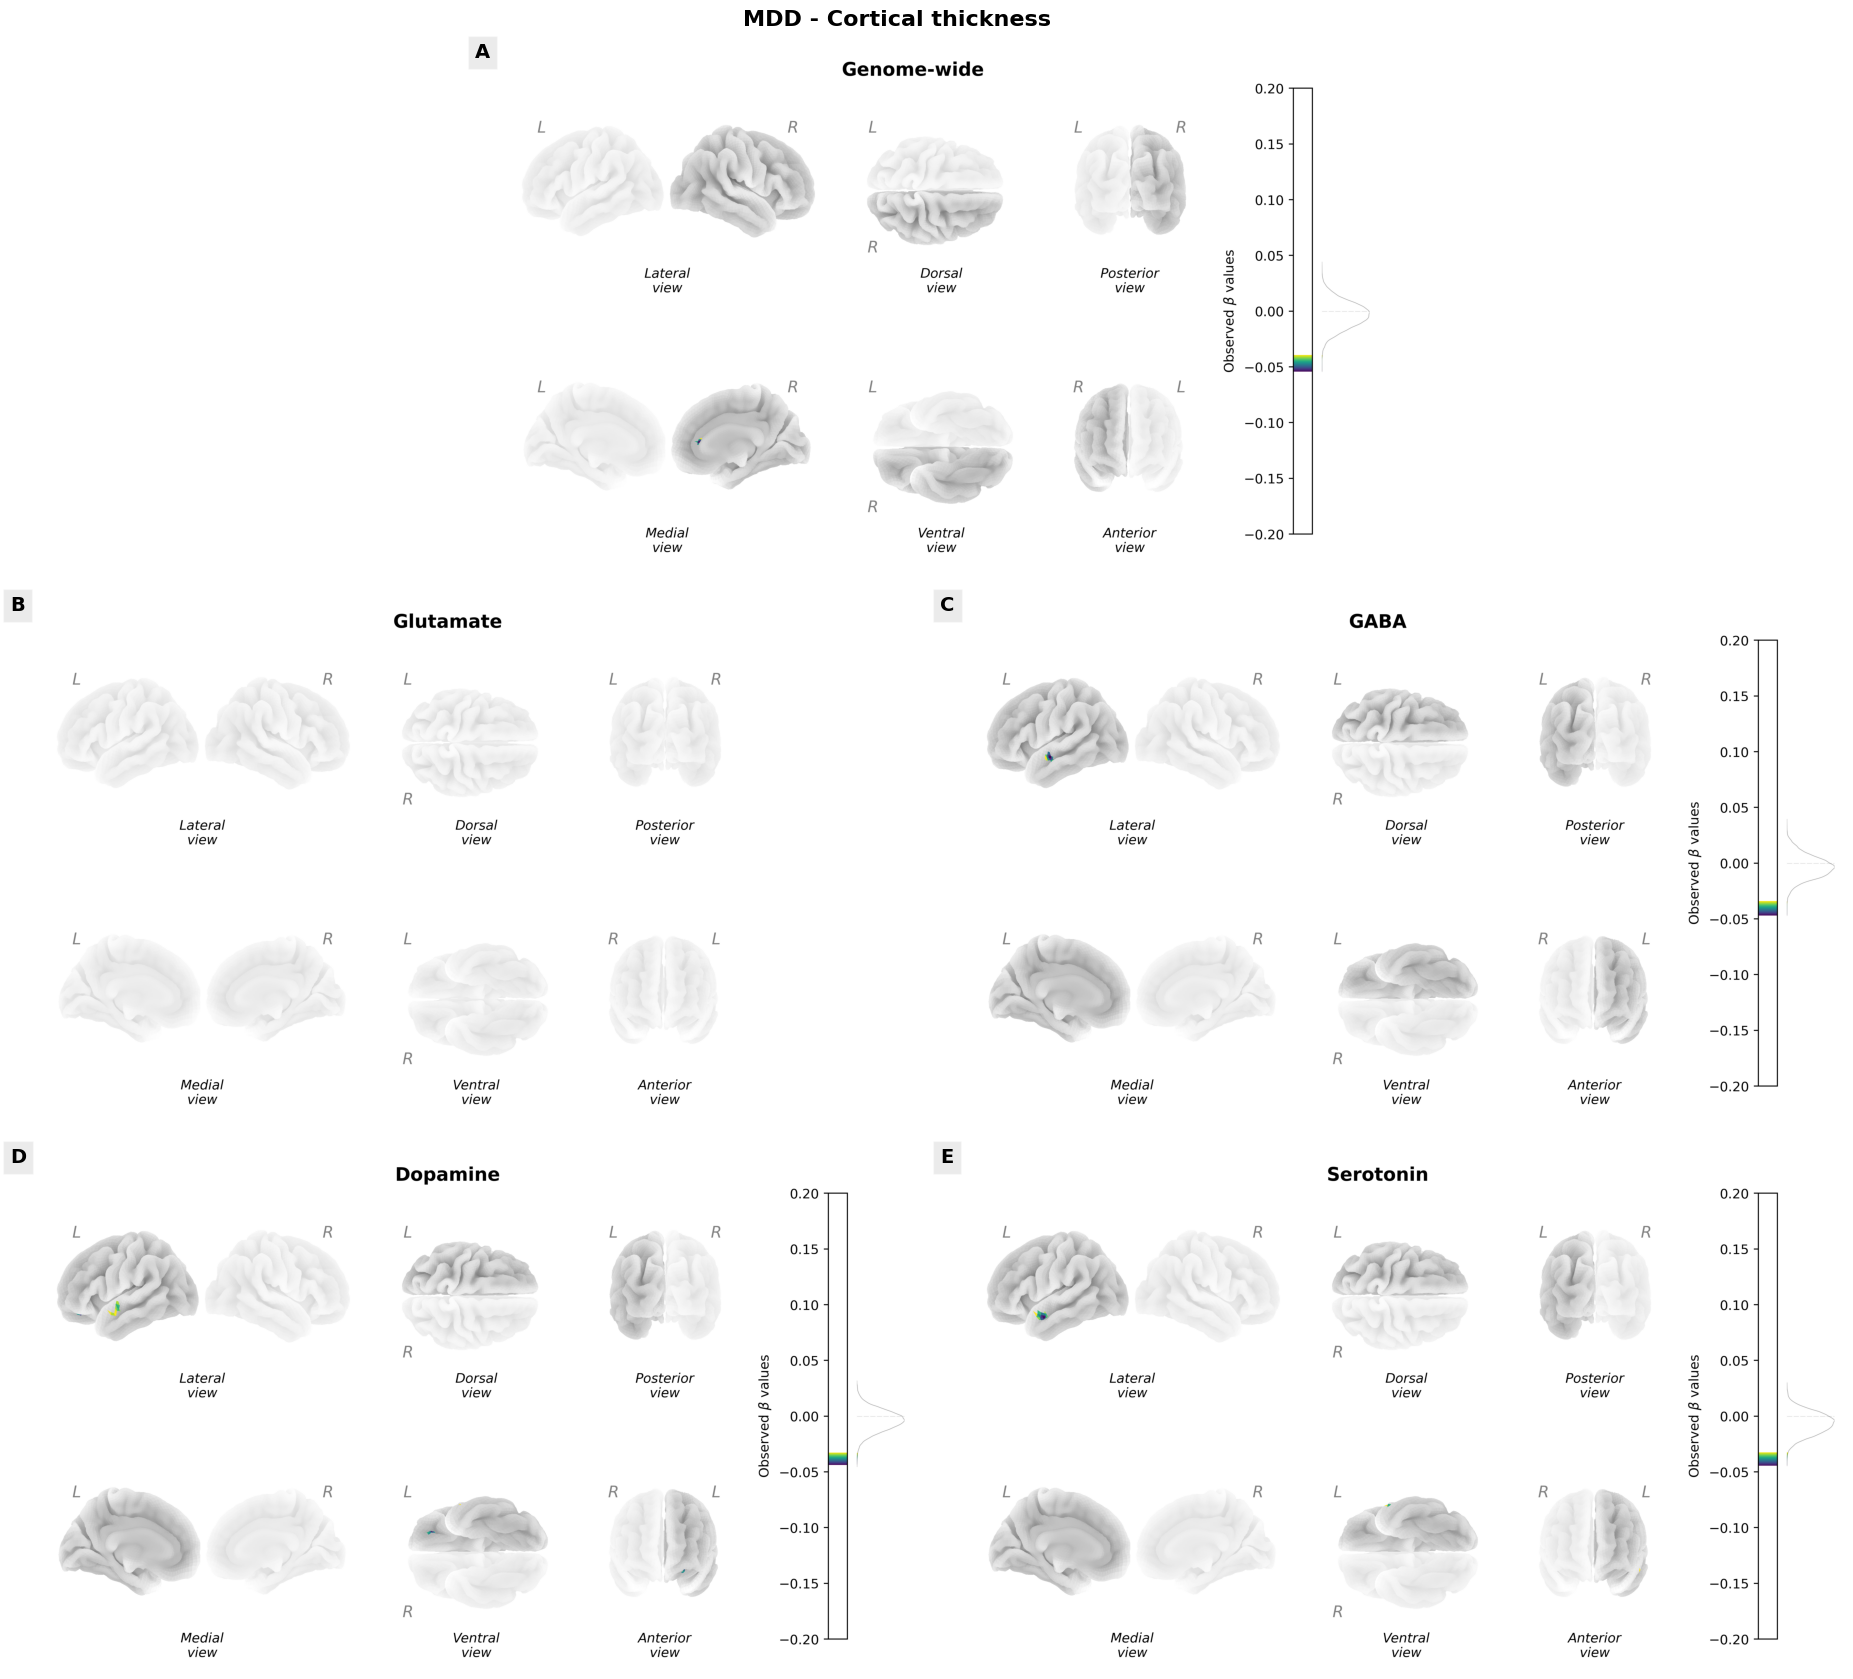

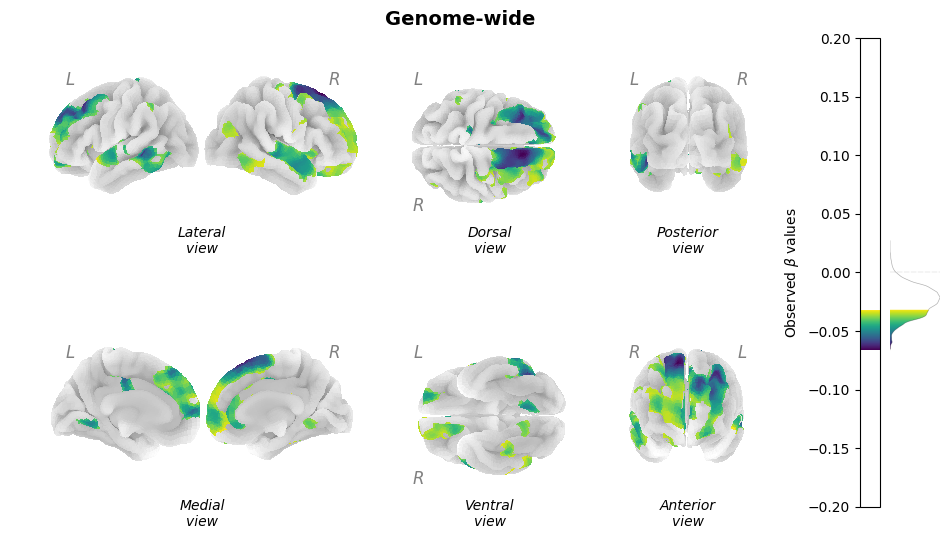

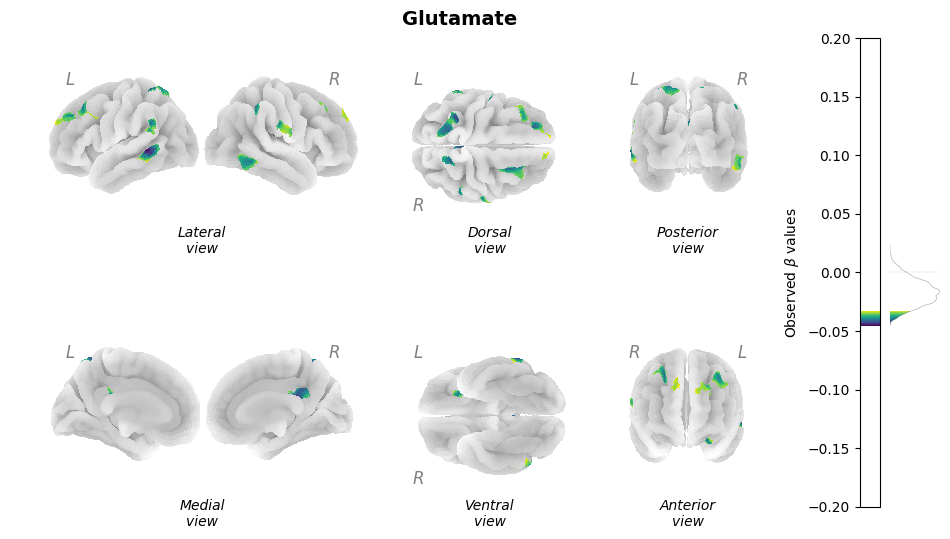

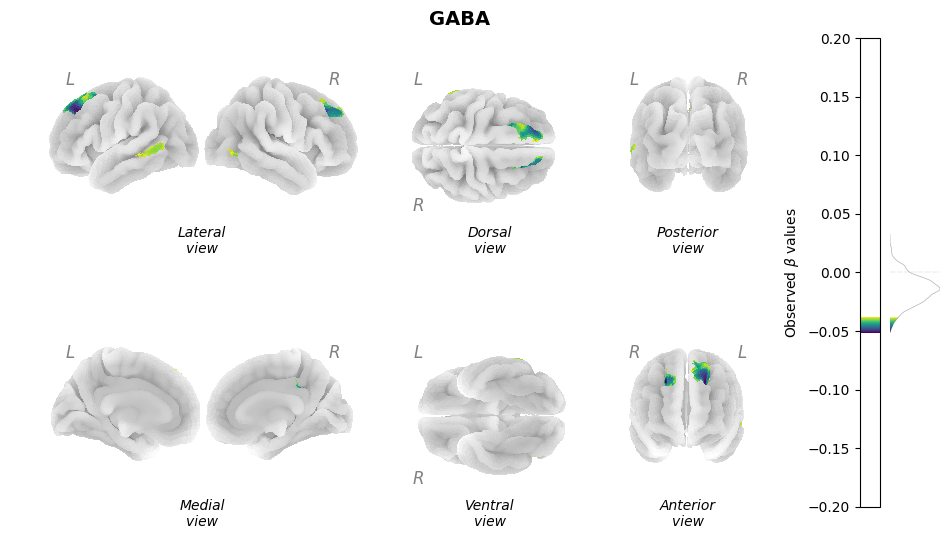

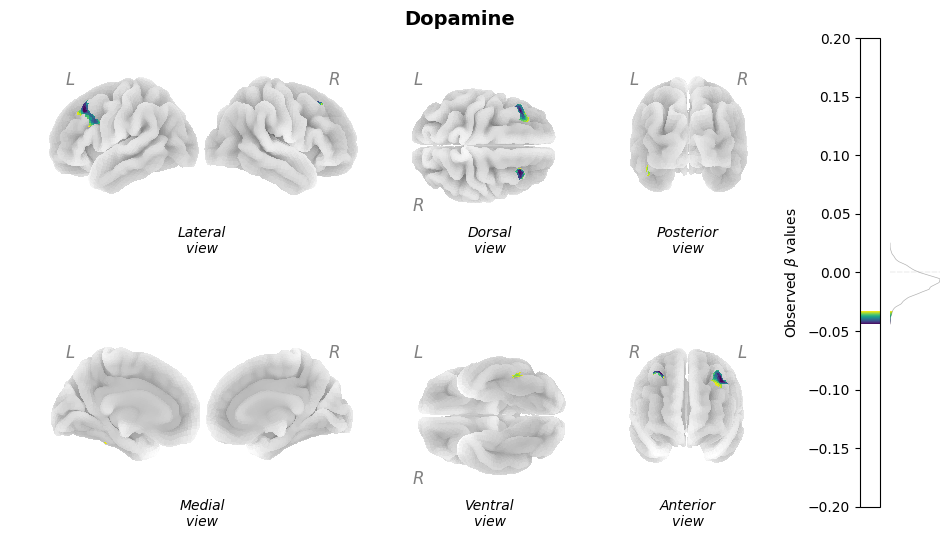

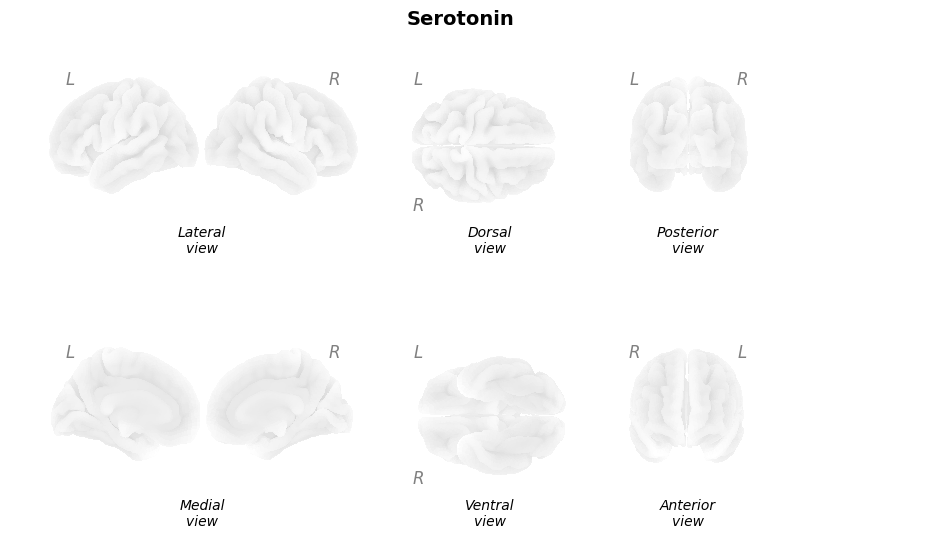

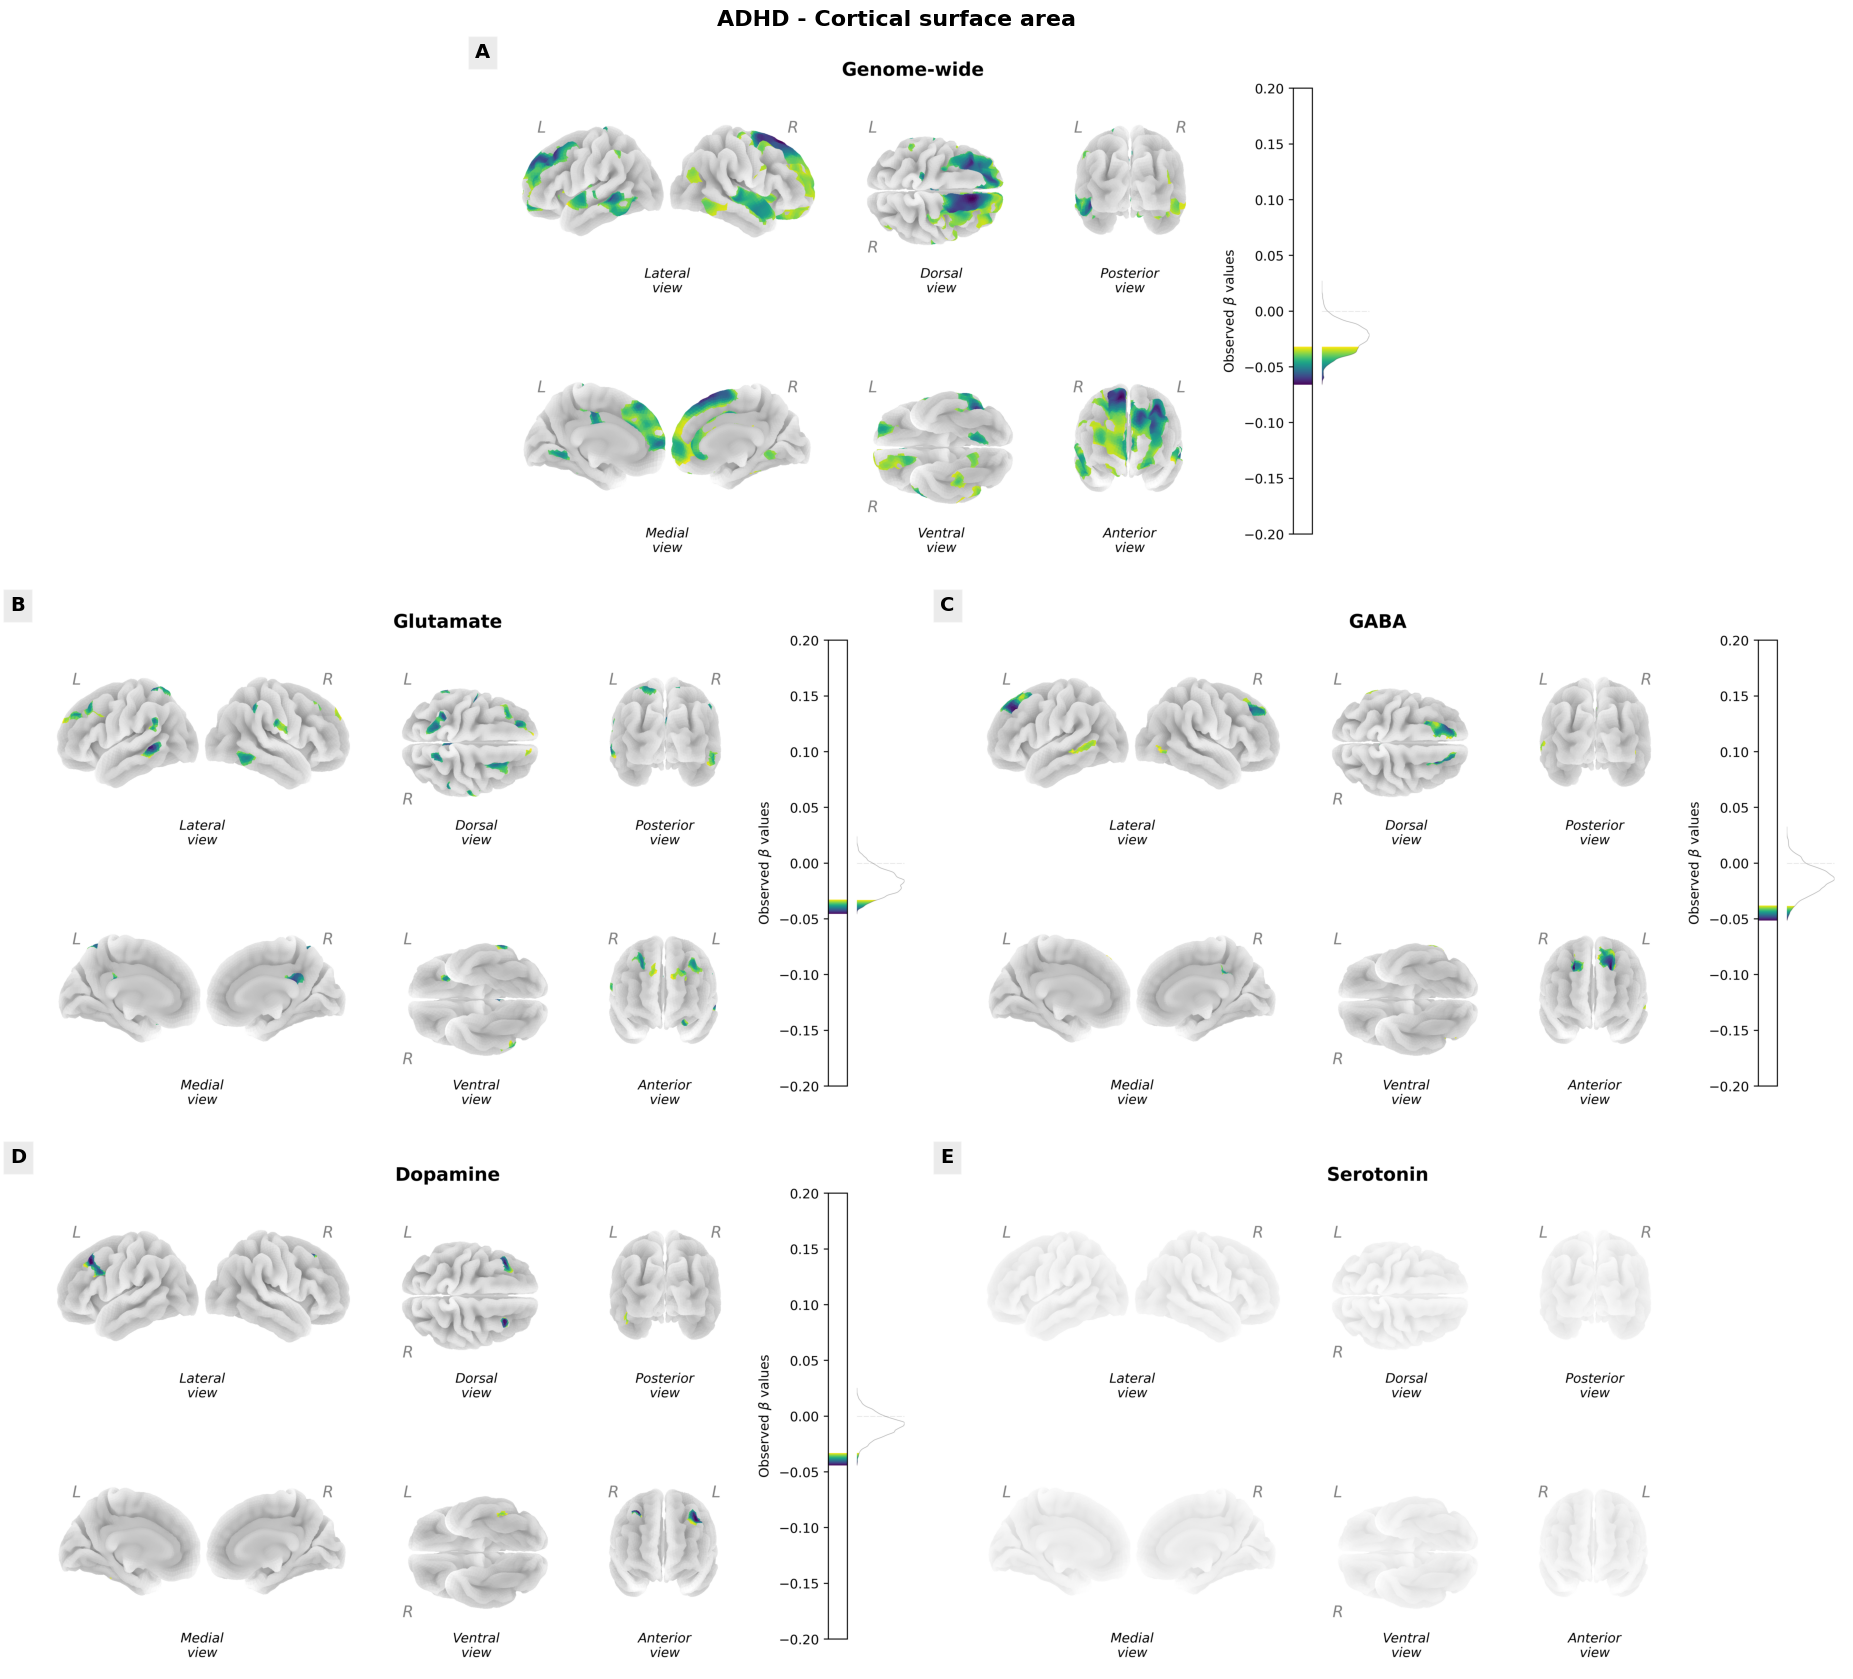

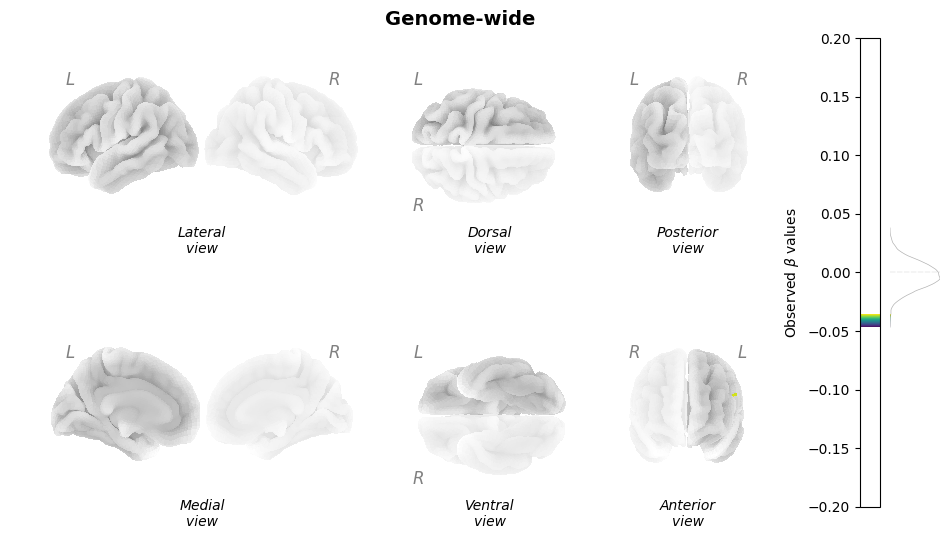

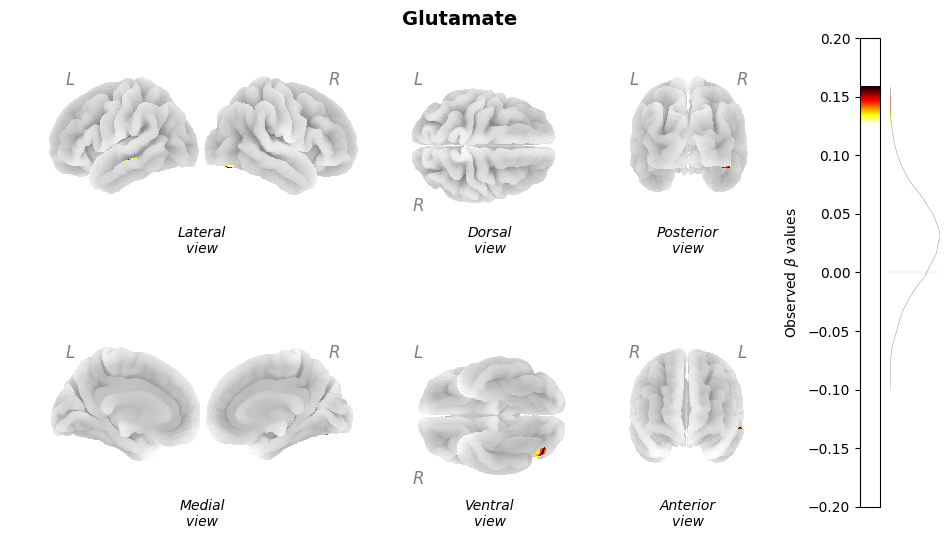

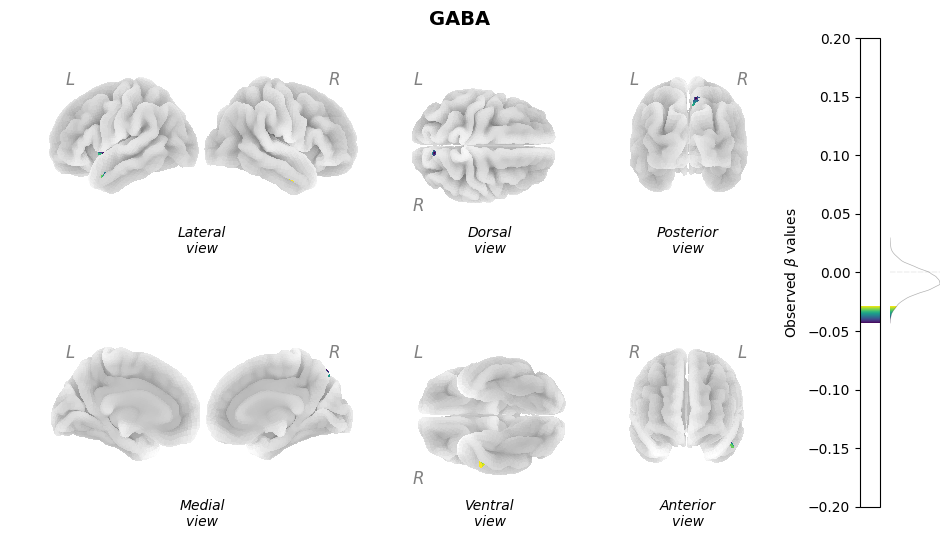

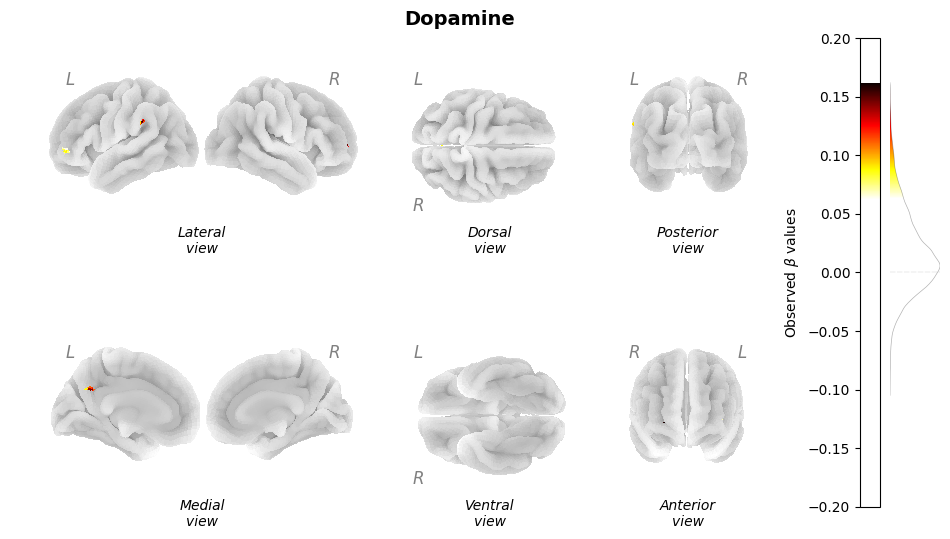

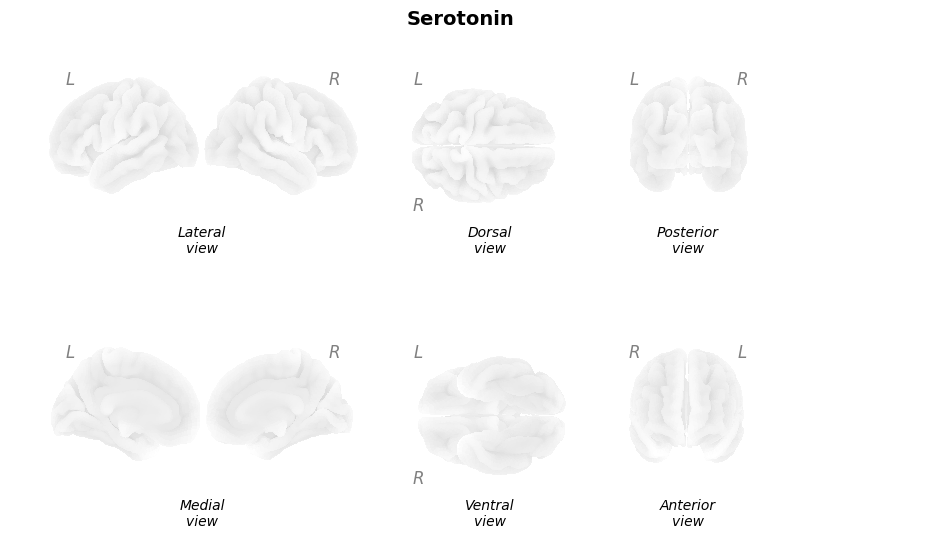

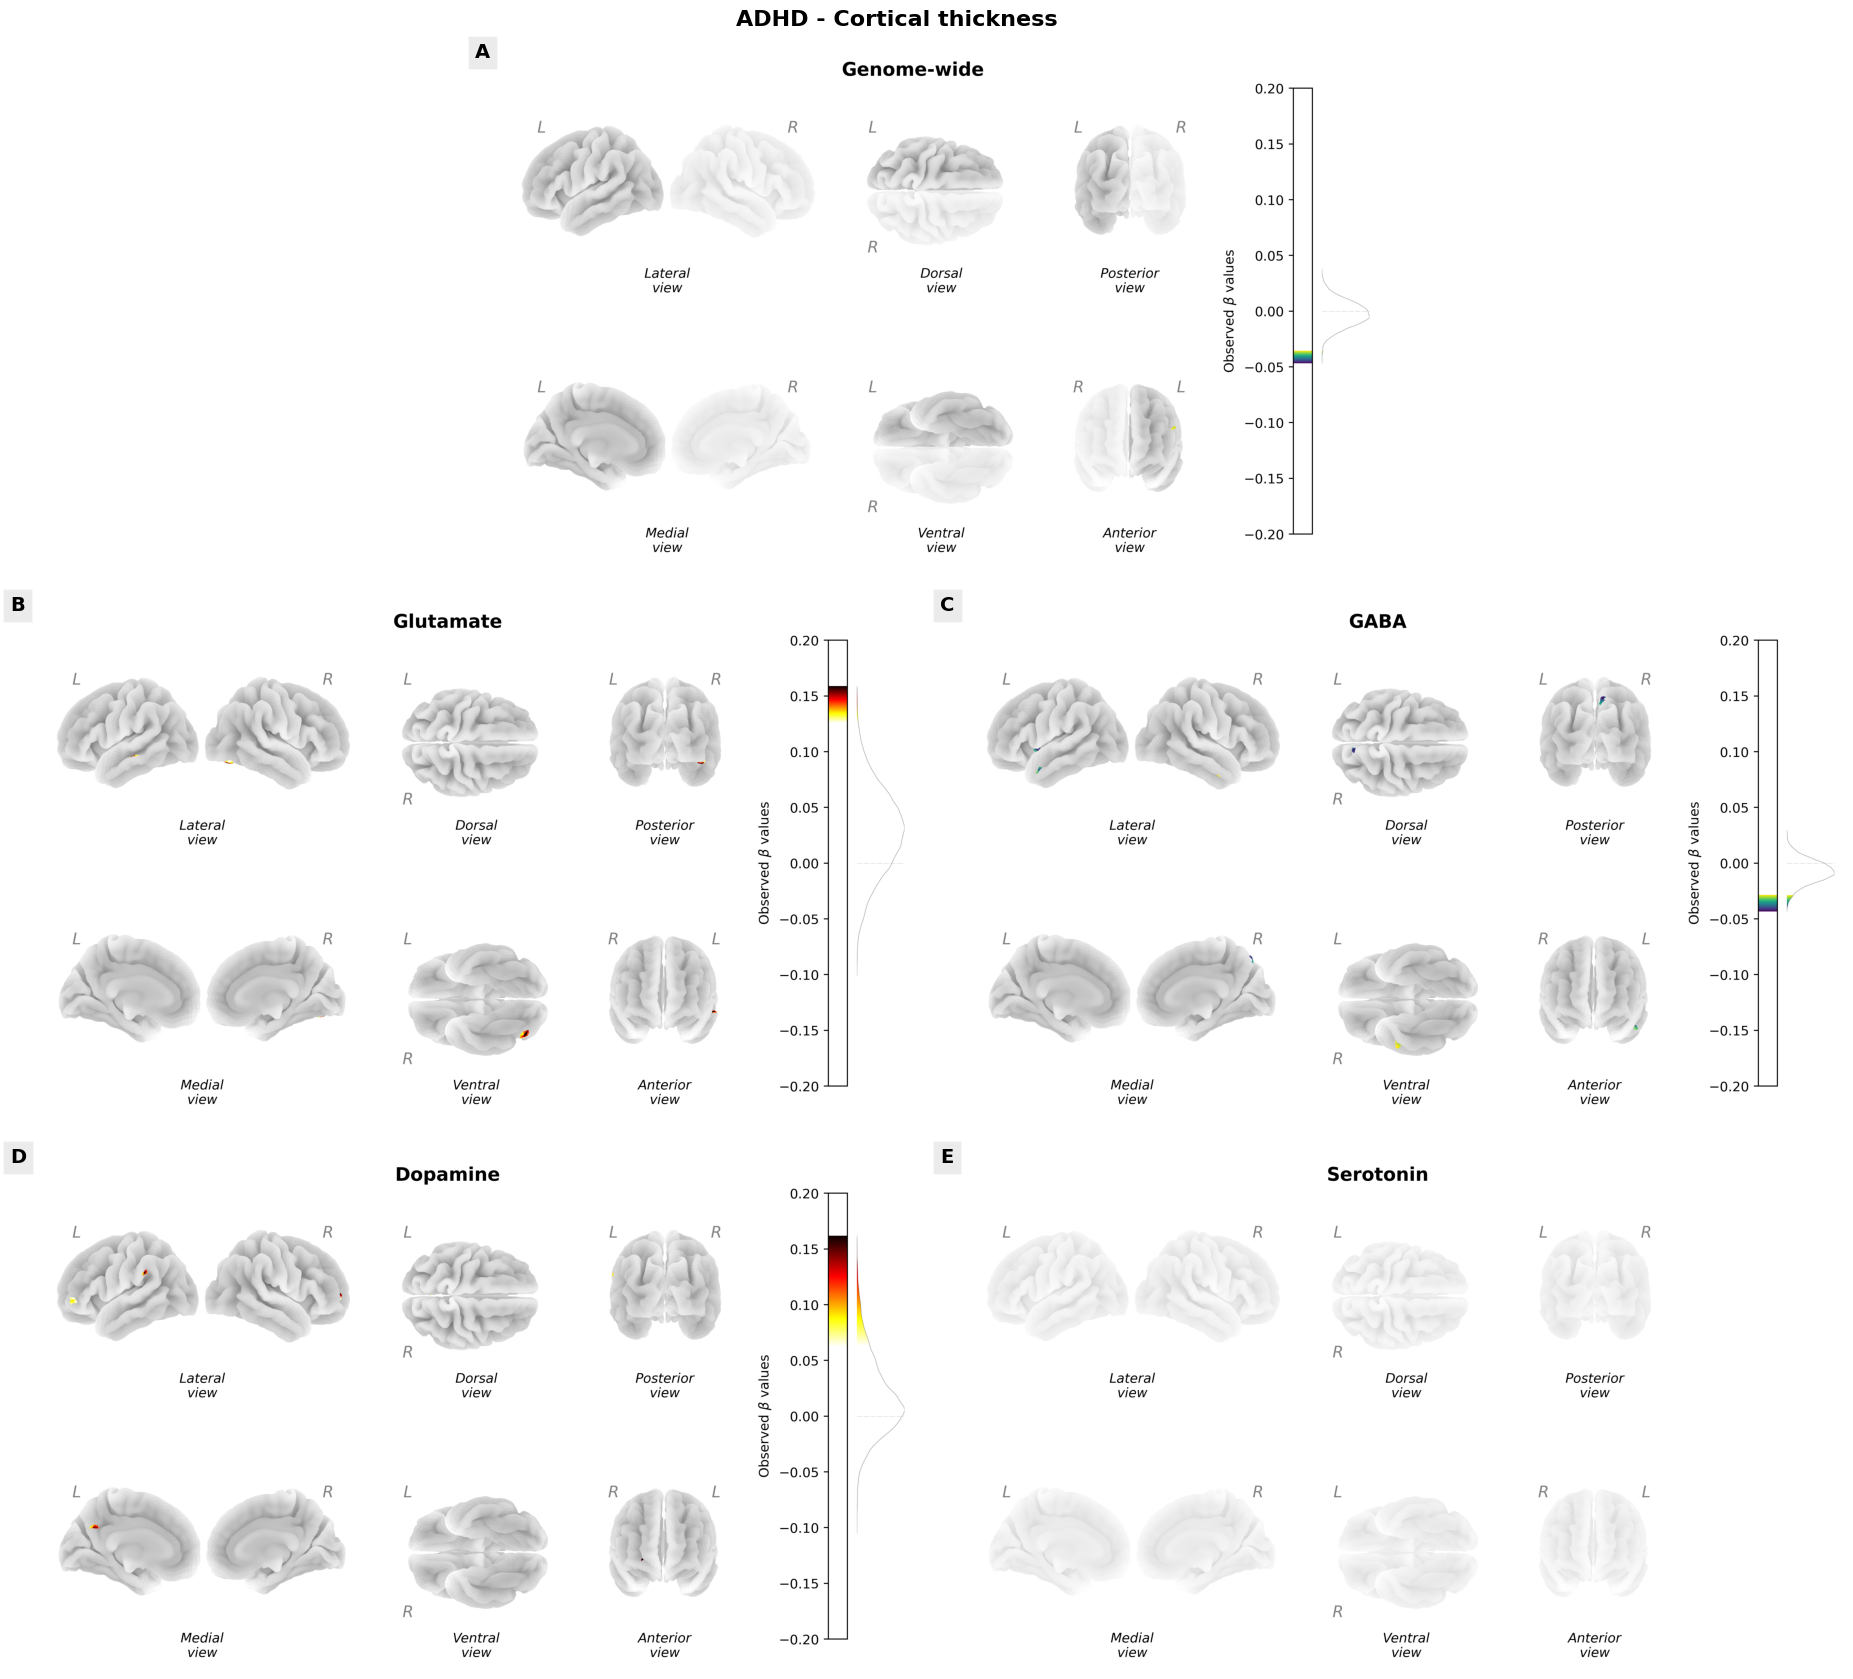

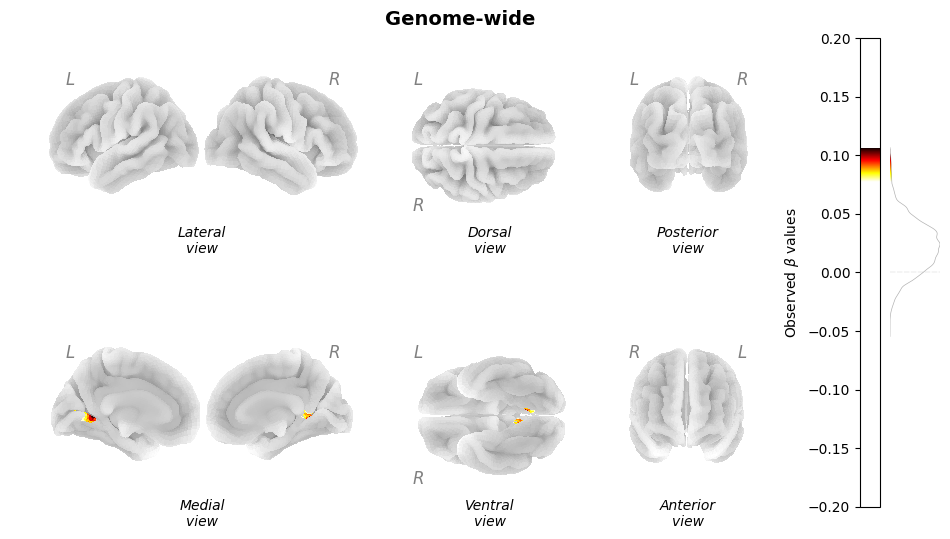

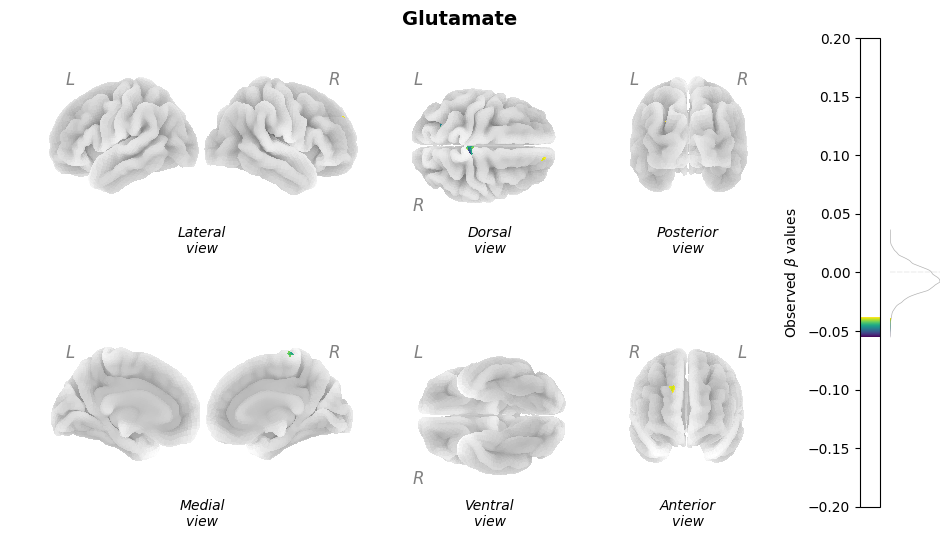

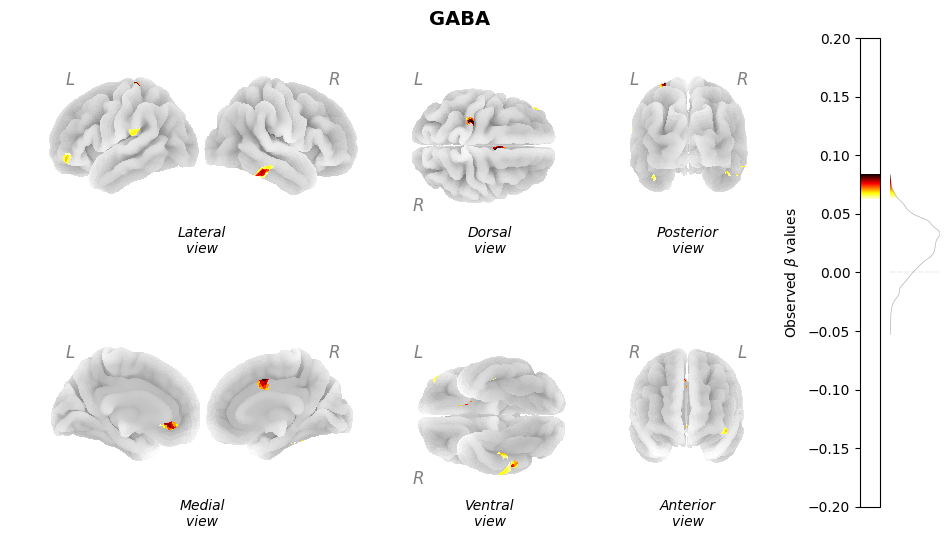

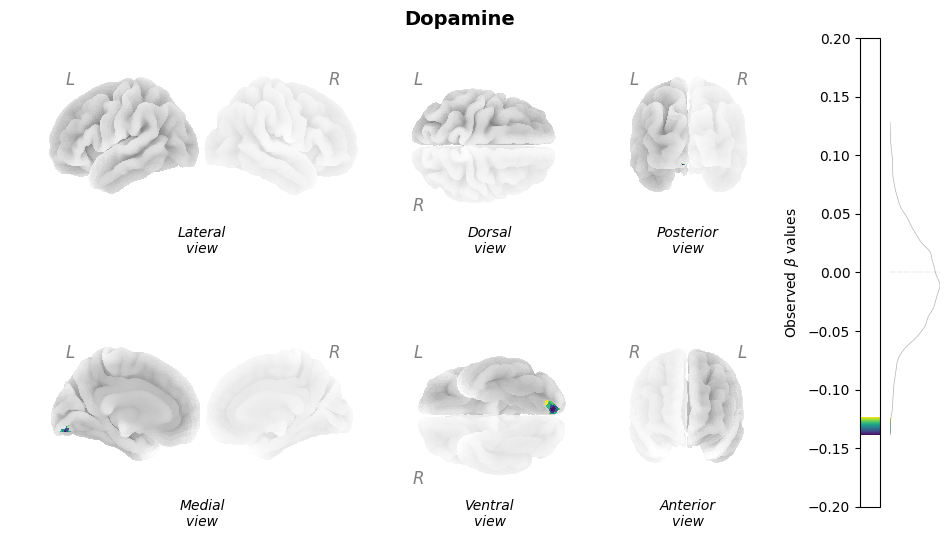

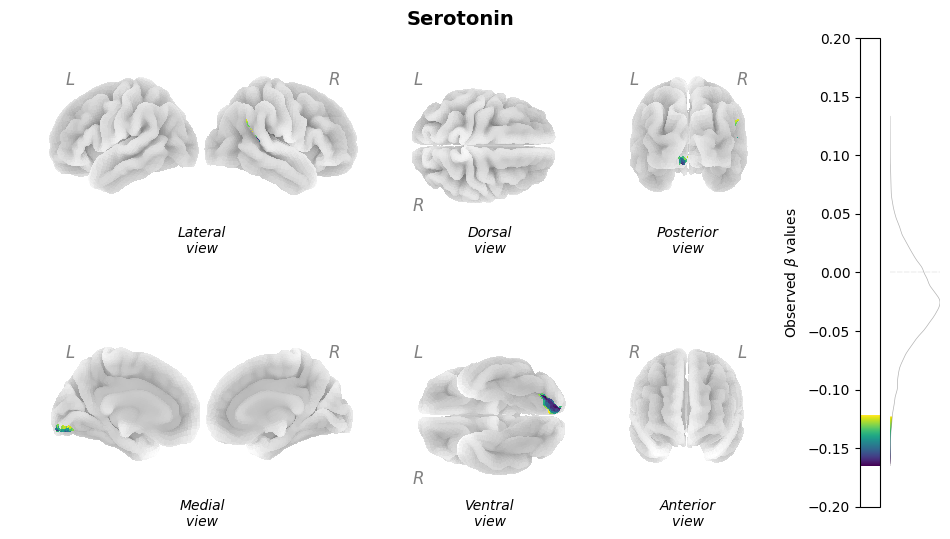

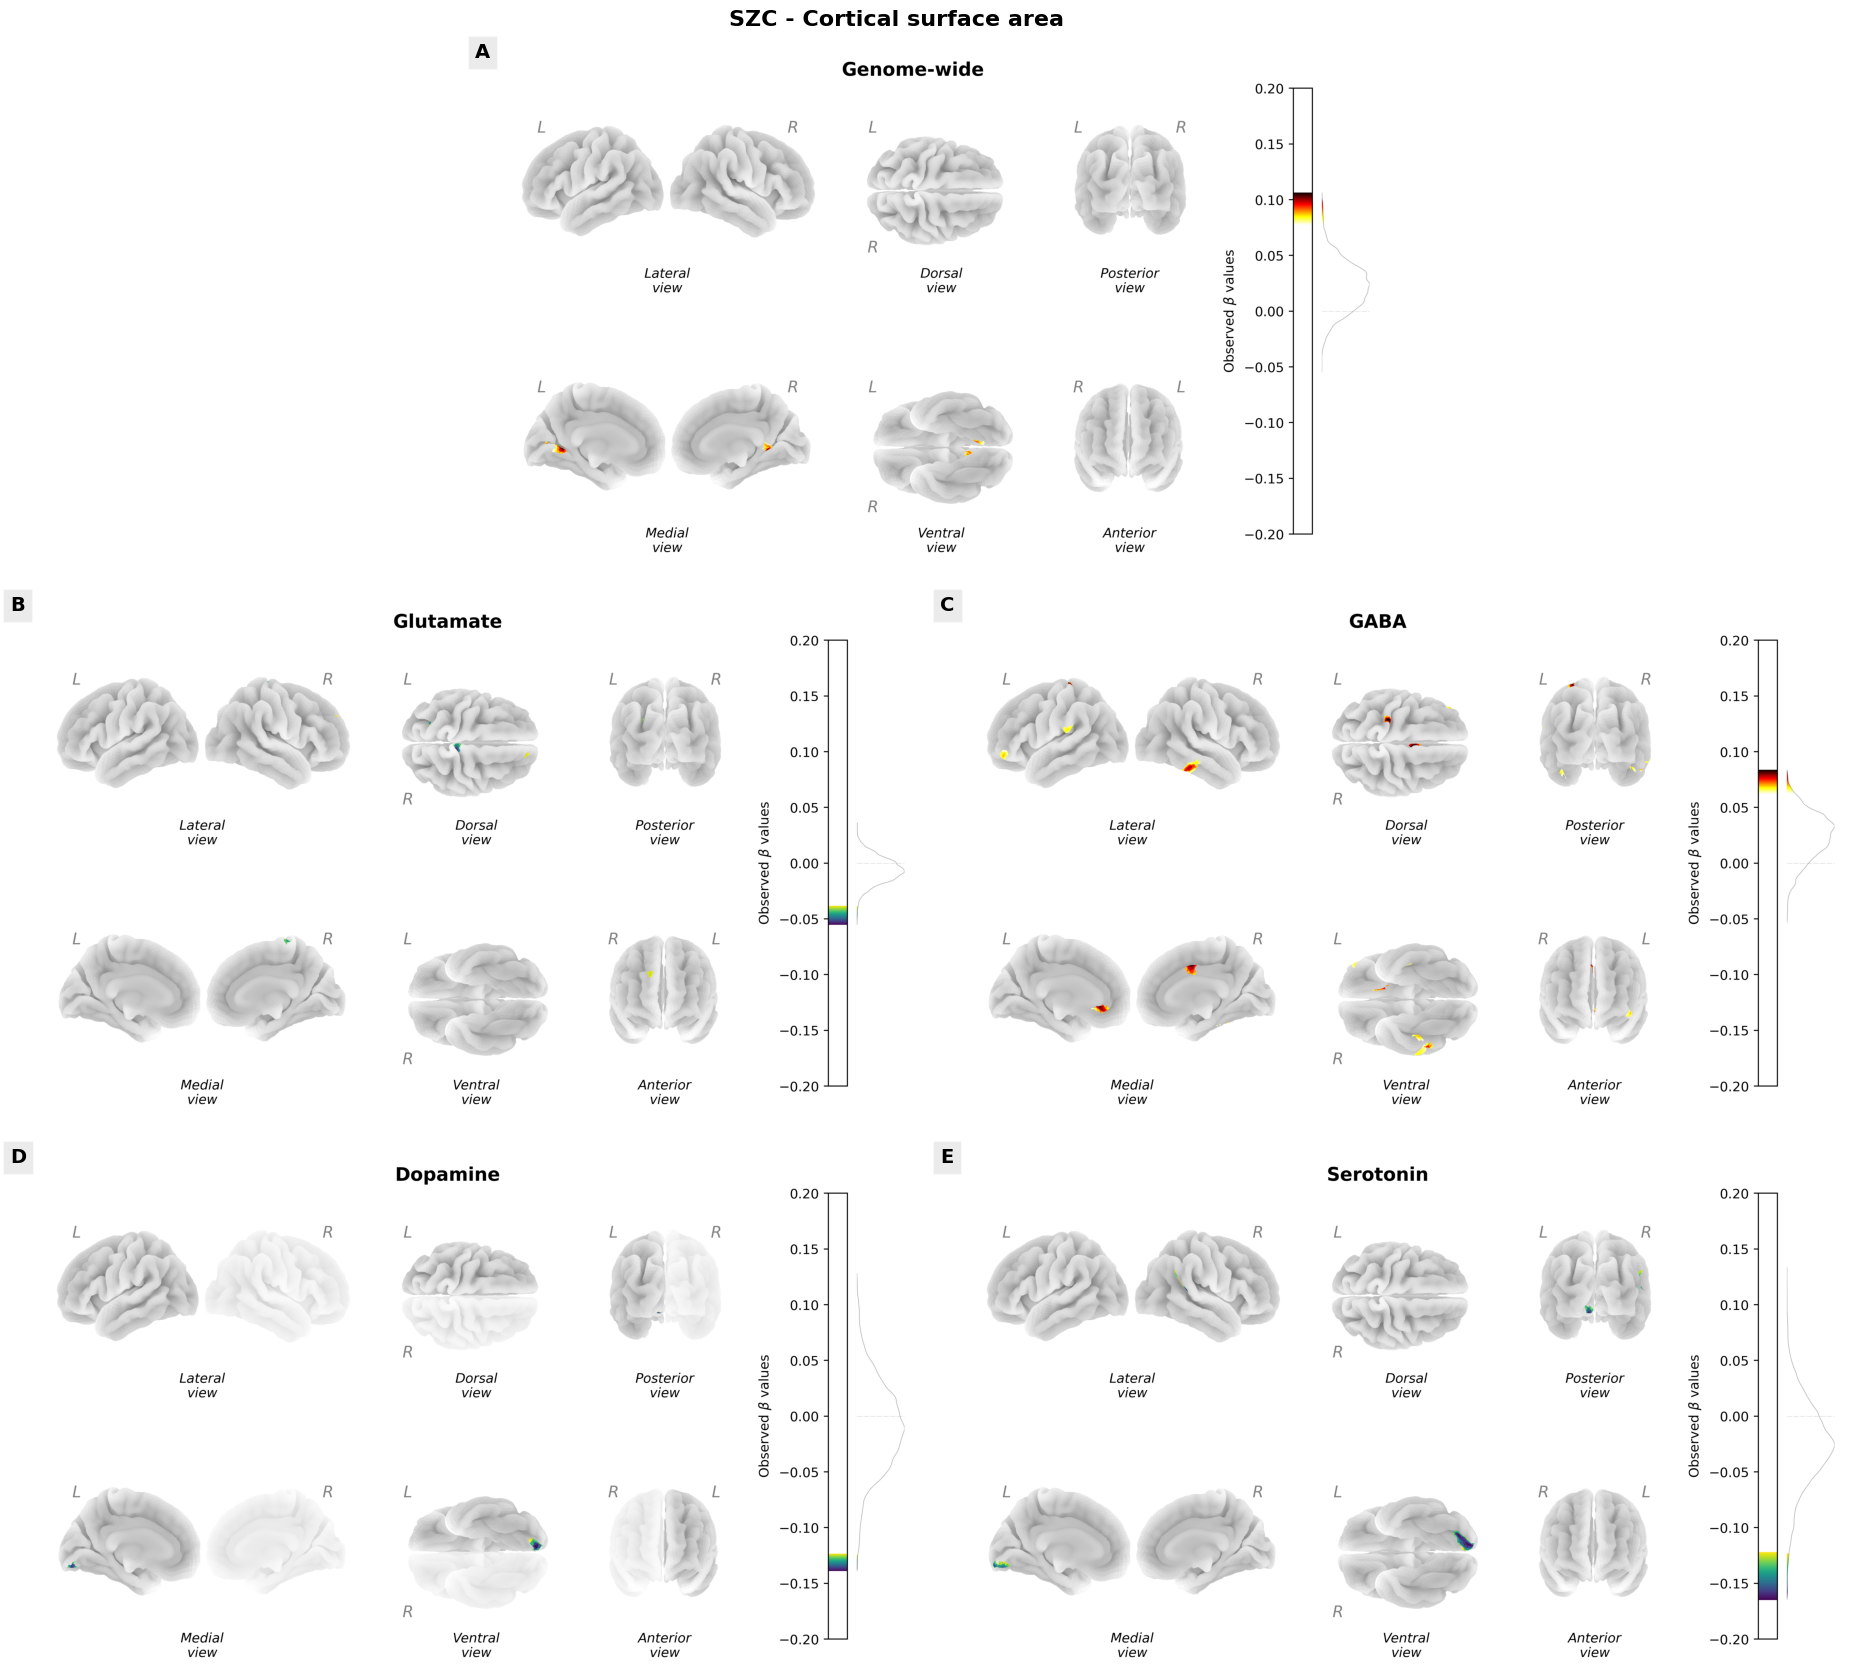

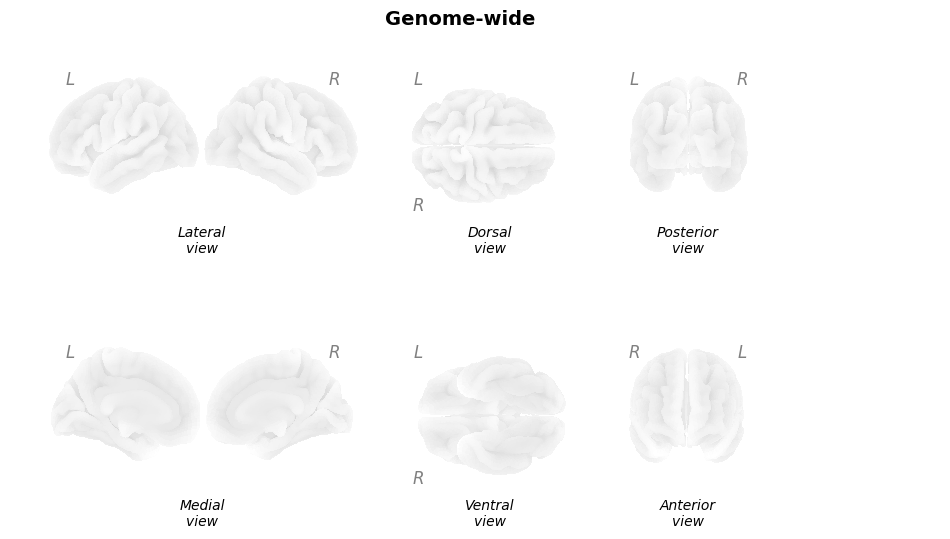

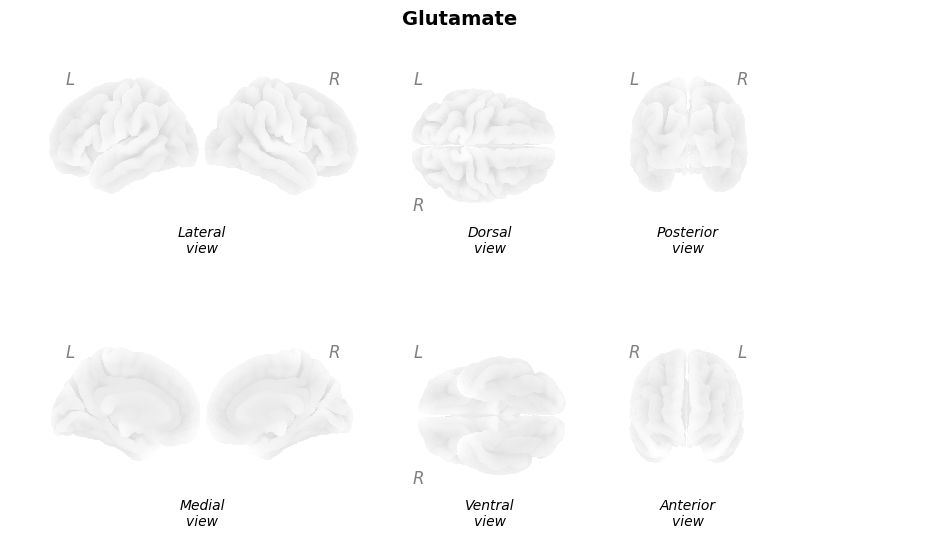

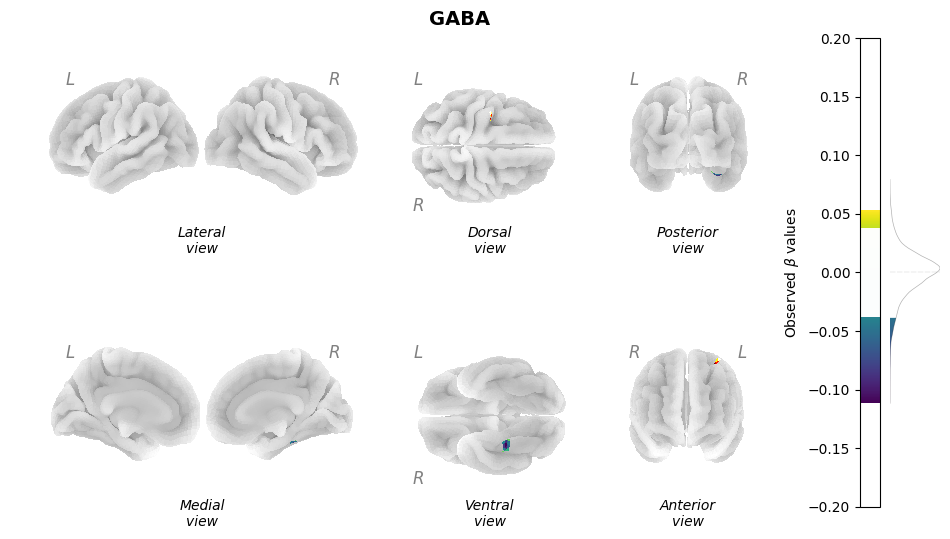

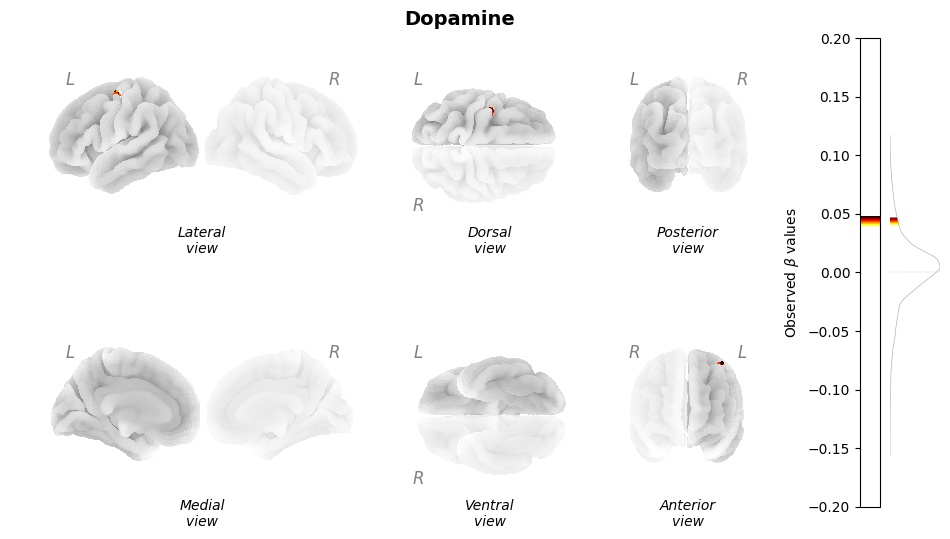

In [ ]:
for exp in ['MDD','ADHD','SZC','p']:
    for ms in ['area','thickness']:
        plot_all_models(exp, ms)
